In [1]:
import SimFunctions
import SimClasses
import SimRNG_Modified
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import probplot, kstest, t
import pickle
from copy import deepcopy

warnings.filterwarnings("ignore")
np.random.seed(1)
ZSimRNG = SimRNG_Modified.InitializeRNSeed()


# Data Loading & Preprocessing 

In [384]:
#subset_df = pd.read_csv("10_station_subset.csv")
subset_df = pd.read_csv("top20_station_subset.csv")
subset_df['End Station Id'] = subset_df['End Station Id'].astype(int)


In [386]:

subset_df[["Start Station Name",
                          "Start Station Id"]].value_counts()


Start Station Name                             Start Station Id
York St / Queens Quay W                        7076                1929
HTO Park (Queens Quay W)                       7175                1810
Ontario Place Blvd / Lake Shore Blvd W (East)  7171                1628
Lake Shore Blvd W / Ontario Dr                 7242                1457
Bathurst St/Queens Quay(Billy Bishop Airport)  7203                1409
Bay St / Queens Quay W (Ferry Terminal)        7016                1331
Queens Quay / Yonge St                         7168                1168
Marilyn Bell Park Tennis Court                 7430                1151
Lower Jarvis / Queens Quay E                   7399                1101
Queens Quay W / Lower Simcoe St                7043                1084
Queens Quay E / Lower Sherbourne St            7261                1020
Fort York  Blvd / Capreol Ct                   7000                 788
King St W / Brant St                           7322                 736


In [3]:
subset_df.head()

,Unnamed: 0,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,NumOfTrips,Start Time (per 30min),End Time (per 30min),Start Time (minutes),End Time (minutes)
0,0,17515475,29.566667,7203,2022-08-01 00:02:00,Bathurst St/Queens Quay(Billy Bishop Airport),7261,2022-08-01 00:32:00,Queens Quay E / Lower Sherbourne St,6908,Casual Member,72,0.0,1.0,2,32
1,18537,17961013,13.583333,7006,2022-08-18 00:14:00,Bay St / College St (East Side),7217,2022-08-18 00:28:00,Soho St / Queen St W,5958,Casual Member,49,0.0,0.0,14,28
2,18536,17961003,14.216667,7006,2022-08-18 00:13:00,Bay St / College St (East Side),7217,2022-08-18 00:27:00,Soho St / Queen St W,2635,Annual Member,49,0.0,0.0,13,27
3,11661,18045153,16.400000,7298,2022-08-21 00:24:00,Bathurst St / Adelaide St W,7076,2022-08-21 00:41:00,York St / Queens Quay W,641,Annual Member,14,0.0,1.0,24,41
4,11660,18013115,17.833333,7298,2022-08-20 00:10:00,Bathurst St / Adelaide St W,7076,2022-08-20 00:28:00,York St / Queens Quay W,3264,Casual Member,14,0.0,0.0,10,28


In [4]:
len(subset_df["Start Station Name"].value_counts())

19

## Arrival Rates

In [5]:
# Convert the start time and end time to minutes
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

# Group the data by station and 30-minute interval, and count the number of trips that started in each group
Start_Station_HalfHour_Arrivals = subset_df.groupby([subset_df['Start Station Name'],subset_df['Start Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='ArrivalRate (per 30min)')
#Start_Station_HalfHour_Arrivals = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='ArrivalRate (per 30min)')

# Calculate the arrival rate at each station and 30-minute interval (trips per hour)
Start_Station_HalfHour_Arrivals['ArrivalRate (per min)'] = Start_Station_HalfHour_Arrivals['ArrivalRate (per 30min)'] / 30
arrival_df = Start_Station_HalfHour_Arrivals.sort_values(by="Start Time (per 30min)")

arrival_df


,Start Station Name,Start Station Id,Start Time (per 30min),ArrivalRate (per 30min),ArrivalRate (per min)
0,Bathurst St / Adelaide St W,7298,0.0,9,0.300000
787,York St / Queens Quay W,7076,0.0,12,0.400000
92,Bay St / College St (East Side),7006,0.0,8,0.266667
744,Union Station,7033,0.0,2,0.066667
134,Bay St / Queens Quay W (Ferry Terminal),7016,0.0,9,0.300000
...,...,...,...,...,...
133,Bay St / College St (East Side),7006,47.0,4,0.133333
743,Soho St / Queen St W,7217,47.0,3,0.100000
91,Bathurst St/Queens Quay(Billy Bishop Airport),7203,47.0,27,0.900000
609,Queens Quay / Yonge St,7168,47.0,13,0.433333


In [472]:
ar_30 = arrival_df["ArrivalRate (per min)"].values
CI_95(ar_30)

(0.7641456582633053, '+/-', 0.050717161382507564)

In [469]:
import scipy.stats as stats
desc = arrival_df.describe()[1:2].values
mean_arrival_30 = desc[0][2]
mean_arrival_min = desc[0][3]

customer_per_30min = mean_arrival_30
customer_per_min = mean_arrival_min
print(f"Customers Per 30 min = {customer_per_30min}")
print(f"Customers Per min = {customer_per_min}")


# Assuming you have a sample of arrival data and have already calculated the sample mean and standard deviation
n = len(arrival_df)
t_value = stats.t.ppf(1-0.05/2, n-1)
se_30 = mean_arrival_30 / (n ** 0.5)
se_min = mean_arrival_min / (n ** 0.5)
ci_30 = (mean_arrival_30 - t_value * se_30, mean_arrival_30 + t_value * se_30)
ci_min = (mean_arrival_min - t_value * se_min,
          mean_arrival_min + t_value * se_min)

print(
    f"Customers Per 30 min = {customer_per_30min:.2f} (95% CI: {ci_30[0]:.2f}, {ci_30[1]:.2f})")
print(
    f"Customers Per min = {customer_per_min:.2f} (95% CI: {ci_min[0]:.2f}, {ci_min[1]:.2f})")


Customers Per 30 min = 22.92436974789916
Customers Per min = 0.7641456582633053
Customers Per 30 min = 22.92 (95% CI: 21.37, 24.48)
Customers Per min = 0.76 (95% CI: 0.71, 0.82)


- There is approx 0.10 customer every minute in the dataset or 1 customer every 10min

## Probability of Destinations

- After finding the probabilities of arriving to a destination from a specific stations, I filled any NA with 0.01 and then normalized to account for random arrivals to different destinations that was not in the data

In [7]:
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

start_end_station_halfhour_trips = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='NumOfTrips')
total_trips = start_end_station_halfhour_trips.groupby(['Start Station Name', 'Start Time (per 30min)'])['NumOfTrips'].sum().reset_index(name='TotalTrips')

start_end_station_prob = pd.merge(start_end_station_halfhour_trips, total_trips, on=['Start Station Name', 'Start Time (per 30min)'])
start_end_station_prob['Probability'] = start_end_station_prob['NumOfTrips'] / start_end_station_prob['TotalTrips']

station_vs_Dest_vs_halfhour = start_end_station_prob.pivot(index=['Start Station Name', 'Start Time (per 30min)'], columns=['End Station Name'], values='Probability').fillna(0)
name_prob_df = station_vs_Dest_vs_halfhour.sort_values(by="Start Time (per 30min)")
name_prob_df.head()

,End Station Name,Bathurst St / Adelaide St W,Bathurst St/Queens Quay(Billy Bishop Airport),Bay St / College St (East Side),Bay St / Queens Quay W (Ferry Terminal),Bay St / Wellesley St W,College St / Major St,Fort York Blvd / Capreol Ct,HTO Park (Queens Quay W),King St W / Brant St,Lake Shore Blvd W / Ontario Dr,Lower Jarvis / Queens Quay E,Marilyn Bell Park Tennis Court,Ontario Place Blvd / Lake Shore Blvd W (East),Queens Quay / Yonge St,Queens Quay E / Lower Sherbourne St,Queens Quay W / Lower Simcoe St,Soho St / Queen St W,Union Station,York St / Queens Quay W
Start Station Name,Start Time (per 30min),,,,,,,,,,,,,,,,,,,
Bathurst St / Adelaide St W,0.0,0.222222,0.000000,0.222222,0.0,0.222222,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.000000,0.111111,0.000000,0.222222
York St / Queens Quay W,0.0,0.083333,0.000000,0.000000,0.0,0.083333,0.0,0.083333,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.250,0.000000,0.166667,0.000000,0.000000,0.333333
Bay St / College St (East Side),0.0,0.125000,0.000000,0.125000,0.0,0.000000,0.0,0.125000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.125,0.000000,0.000000,0.250000,0.250000,0.000000
Union Station,0.0,0.000000,0.000000,0.000000,0.0,0.500000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000,0.500000,0.000000,0.000000,0.000000,0.000000
Bay St / Queens Quay W (Ferry Terminal),0.0,0.000000,0.111111,0.000000,0.0,0.000000,0.0,0.000000,0.111111,0.0,0.0,0.111111,0.0,0.111111,0.000,0.222222,0.000000,0.000000,0.333333,0.000000


Real Probability
End Station Name
Bathurst St / Adelaide St W                      0.0
Bathurst St/Queens Quay(Billy Bishop Airport)    0.0
Bay St / College St (East Side)                  0.1
Bay St / Queens Quay W (Ferry Terminal)          0.0
Bay St / Wellesley St W                          0.0
College St / Major St                            0.0
Fort York  Blvd / Capreol Ct                     0.0
HTO Park (Queens Quay W)                         0.0
King St W / Brant St                             0.1
Lake Shore Blvd W / Ontario Dr                   0.2
Lower Jarvis / Queens Quay E                     0.0
Marilyn Bell Park Tennis Court                   0.5
Ontario Place Blvd / Lake Shore Blvd W (East)    0.0
Queens Quay / Yonge St                           0.0
Queens Quay E / Lower Sherbourne St              0.0
Queens Quay W / Lower Simcoe St                  0.1
Soho St / Queen St W                             0.0
Union Station                                    0.0
York St / Qu

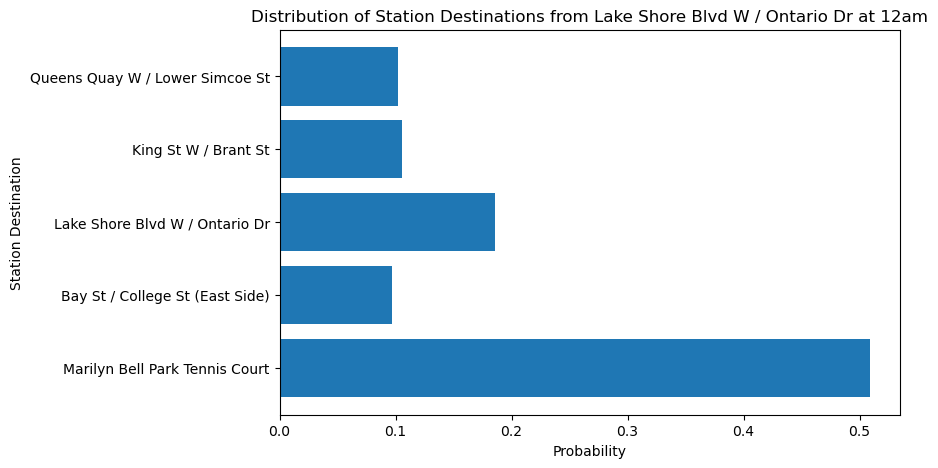

In [8]:
def ChoosingRoute(prob_df, start_station, start_time):
    try:
        start_row = prob_df.loc[(start_station, start_time)]
        probs = start_row.values
        destination = np.random.choice(start_row.index, p=probs)
        return destination
    except KeyError:
        print(
            f"No data found for start station '{start_station}' and start time '{start_time}'")


monte_carlo = []
for i in range(1000):
    start_station = 'Lake Shore Blvd W / Ontario Dr'
    start_time = 0  # 30-minute interval index
    destination = ChoosingRoute(name_prob_df, start_station, start_time)
    if destination is not None:
        monte_carlo.append(destination)


prob = {}
for s in monte_carlo:
    if s in prob:
        prob[s] += 1
    else:
        prob[s] = 1
for s in prob:
    prob[s] /= len(monte_carlo)

print("Real Probability")
print(name_prob_df.loc[(start_station, start_time)])
print()
print("Simulated Probability")
print(prob)
# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.barh(list(prob.keys()), list(prob.values()))
plt.xlabel('Probability')
plt.ylabel('Station Destination')
plt.title(
    f'Distribution of Station Destinations from {start_station} at 12am')
plt.show()


Real Probability
End Station Name
Bathurst St / Adelaide St W                      0.000000
Bathurst St/Queens Quay(Billy Bishop Airport)    0.000000
Bay St / College St (East Side)                  0.000000
Bay St / Queens Quay W (Ferry Terminal)          0.161290
Bay St / Wellesley St W                          0.000000
College St / Major St                            0.000000
Fort York  Blvd / Capreol Ct                     0.096774
HTO Park (Queens Quay W)                         0.161290
King St W / Brant St                             0.032258
Lake Shore Blvd W / Ontario Dr                   0.129032
Lower Jarvis / Queens Quay E                     0.064516
Marilyn Bell Park Tennis Court                   0.129032
Ontario Place Blvd / Lake Shore Blvd W (East)    0.032258
Queens Quay / Yonge St                           0.064516
Queens Quay E / Lower Sherbourne St              0.032258
Queens Quay W / Lower Simcoe St                  0.032258
Soho St / Queen St W                  

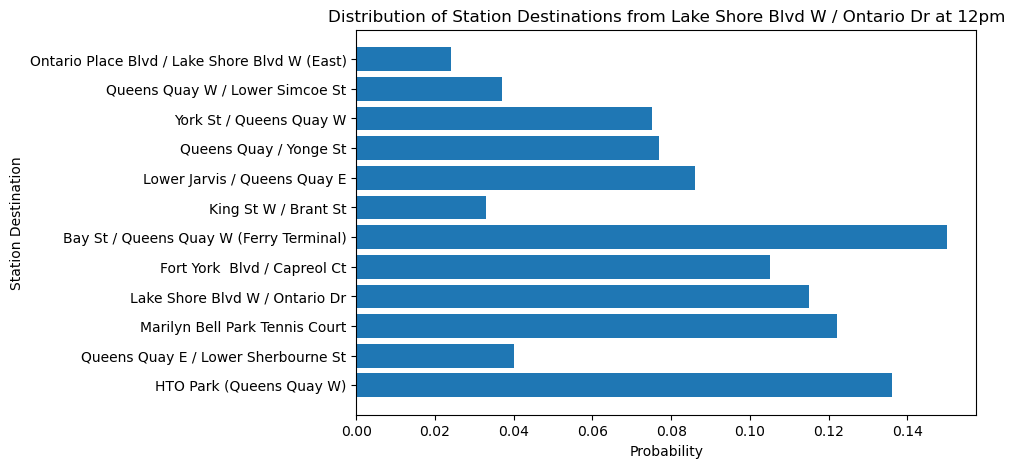

In [9]:
def ChoosingRoute(prob_df, start_station, start_time):
    try:
        start_row = prob_df.loc[(start_station, start_time)]
        probs = start_row.values
        destination = np.random.choice(start_row.index, p=probs)
        return destination
    except KeyError:
        print(
            f"No data found for start station '{start_station}' and start time '{start_time}'")


monte_carlo = []
for i in range(1000):
    start_station = 'Lake Shore Blvd W / Ontario Dr'
    start_time = 24  # 30-minute interval index
    destination = ChoosingRoute(name_prob_df, start_station, start_time)
    if destination is not None:
        monte_carlo.append(destination)


prob = {}
for s in monte_carlo:
    if s in prob:
        prob[s] += 1
    else:
        prob[s] = 1
for s in prob:
    prob[s] /= len(monte_carlo)

print("Real Probability")
print(name_prob_df.loc[(start_station, start_time)])
print()
print("Simulated Probability")
print(prob)
# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.barh(list(prob.keys()), list(prob.values()))
plt.xlabel('Probability')
plt.ylabel('Station Destination')
plt.title(
    f'Distribution of Station Destinations from {start_station} at {start_time//2}pm')
plt.show()


In [10]:
station_vs_Dest_vs_halfhour = start_end_station_prob.pivot(index=['Start Station Id', 'Start Time (per 30min)'], columns=['End Station Id'], values='Probability').fillna(0)
prob_df = station_vs_Dest_vs_halfhour.sort_values(by="Start Time (per 30min)")
prob_df


,End Station Id,7000,7006,7016,7030,7033,7043,7076,7078,7168,7171,7175,7203,7217,7242,7261,7298,7322,7399,7430
Start Station Id,Start Time (per 30min),,,,,,,,,,,,,,,,,,,
7000,0.0,0.000000,0.000000,0.0,0.0,1.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
7006,0.0,0.125000,0.125000,0.0,0.0,0.25,0.0,0.000000,0.0,0.125000,0.0,0.0,0.000000,0.250000,0.0,0.000000,0.125000,0.000000,0.000000,0.0
7399,0.0,0.000000,0.000000,0.0,0.0,0.00,0.2,0.200000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.200000,0.000000,0.000000,0.400000,0.0
7033,0.0,0.000000,0.000000,0.0,0.5,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.0
7261,0.0,0.000000,0.000000,0.0,0.0,0.00,0.0,0.166667,0.0,0.333333,0.0,0.0,0.000000,0.000000,0.0,0.333333,0.000000,0.000000,0.166667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7006,47.0,0.500000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
7322,47.0,0.285714,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.142857,0.428571,0.142857,0.0
7000,47.0,0.333333,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.333333,0.0,0.333333,0.000000,0.000000,0.000000,0.0


## Trip Durations

### Different Stations Destinations

In [11]:
with open('top20_diff_google_bike_trip_est.pickle', 'rb') as f:
    google_bike_trip = pickle.load(f)

diff_stations_subset_df = pd.read_csv("diff_stations_subset_df.csv")
google = pd.DataFrame((np.array(google_bike_trip)), columns=["Google"])
observed = pd.DataFrame(np.array((diff_stations_subset_df["Trip_Duration"].values)), columns=["Observed"])
trip_reg_df = pd.DataFrame({"Observed": np.array((diff_stations_subset_df["Trip_Duration"].values)*60), "Google": np.array(google_bike_trip)})
trip_reg_df.head()


,Observed,Google
0,1774.0,582
1,1761.0,582
2,1098.0,582
3,892.0,582
4,1310.0,582


In [12]:
trip_reg_df.describe()


,Observed,Google
count,16202.000000,16202.000000
mean,892.046599,455.499198
std,459.080990,274.908215
min,64.000000,34.000000
25%,504.000000,249.000000
50%,841.500000,421.000000
75%,1246.000000,644.000000
max,1980.000000,1521.000000


Error Mean -1.5261626468615904e-16
Residual Variance: 0.25580459588191384

Beta: 0.4513542745881248
Intercept: 3.974270551809947
R^2: 0.3143043103068821


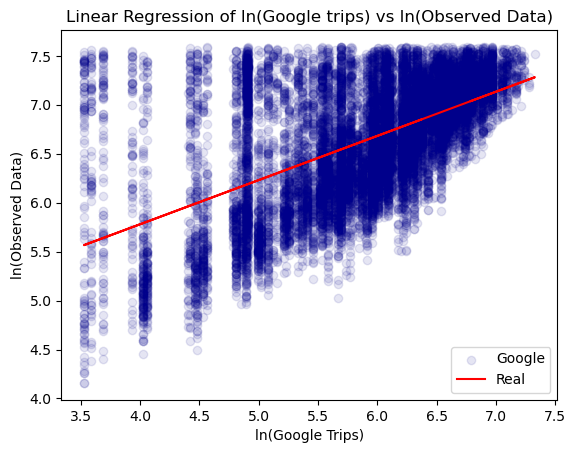

In [13]:
np.random.seed(1)

X = np.log(trip_reg_df["Google"].values)
y = np.log(trip_reg_df["Observed"].values)

X = np.array(X).reshape(-1, 1)

# set regression through the origin
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
predictions = model.predict(X)
score = model.score(X, y)
beta = model.coef_[0]
intercept = model.intercept_

residuals = y - predictions
residual_var = np.var(residuals)
residual_mean = np.mean(residuals)

print("Error Mean", residual_mean)
print("Residual Variance:", residual_var)
print()
print('Beta:', beta)
print('Intercept:', intercept)
print("R^2:", score)

plt.scatter(X, y, color='darkblue', alpha=0.1)
plt.plot(X, predictions, color='red')
plt.title("Linear Regression of ln(Google trips) vs ln(Observed Data)")
plt.ylabel("ln(Observed Data)")
plt.xlabel("ln(Google Trips)")
plt.legend(["Google", "Real"], loc="lower right")
plt.show()


Pre Residual Mean -1.5261626468615904e-16
Pre Residual Variance: 0.25580459588191384

New Resiudal Mean -5.530146832449613e-16
New Residual Variance: 0.12858666740184382

Beta: 0.47504569391691565
Intercept: 3.8372405086866
R^2: 0.6553176721259963


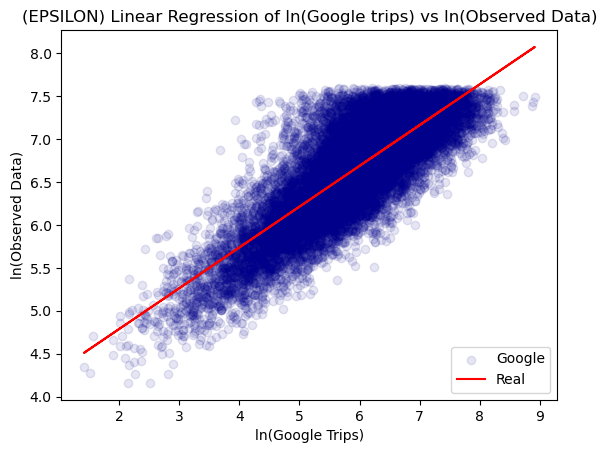

In [14]:
np.random.seed(1)

X = np.log(trip_reg_df["Google"].values)
y = np.log(trip_reg_df["Observed"].values)

X_i = np.array(X).reshape(-1, 1)

# set regression through the origin
model = LinearRegression(fit_intercept=True)
model.fit(X_i, y)
predictions = model.predict(X_i)
score = model.score(X_i, y)
beta = model.coef_[0]
intercept = model.intercept_

residuals = y - predictions
residual_mean = np.mean(residuals)
residual_var = np.var(residuals)
residual_std = np.std(residuals)

error_sd = np.sqrt(residual_var)
errors = np.random.normal(loc=residual_mean, scale=residual_std, size=len(residuals))
epsilon = residuals - errors

new_X = X + epsilon
new_X_i = np.array(new_X).reshape(-1, 1)

# Fit linear regression model
model = LinearRegression(fit_intercept=True)
model.fit(new_X_i, y)
new_predictions = model.predict(new_X_i)

# Calculate R-squared and print results
r2 = model.score(new_X_i, y)
new_beta = model.coef_[0]
new_intercept = model.intercept_

new_residuals = y - new_predictions
new_residual_mean = np.mean(new_residuals)
new_residual_var = np.var(new_residuals)
new_residual_std = np.std(new_residuals)
print("Pre Residual Mean", residual_mean)
print("Pre Residual Variance:", residual_var)
print()

print("New Resiudal Mean", new_residual_mean)
print("New Residual Variance:", new_residual_var)
print()
print('Beta:', new_beta)
print('Intercept:', new_intercept)
print("R^2:", r2)

plt.scatter(new_X_i, y, color='darkblue', alpha=0.1)
plt.plot(new_X_i, new_predictions, color='red')
plt.title("(EPSILON) Linear Regression of ln(Google trips) vs ln(Observed Data)")
plt.ylabel("ln(Observed Data)")
plt.xlabel("ln(Google Trips)")
plt.legend(["Google", "Real"], loc="lower right")
plt.show()


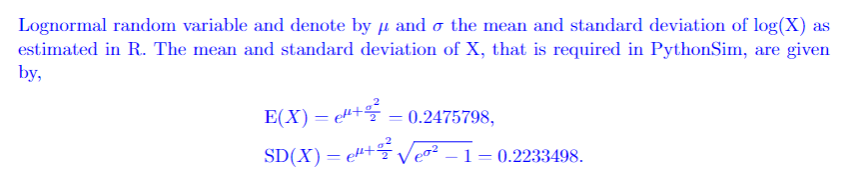

In [15]:
global E_x, SD_X

u = residual_mean
std = np.sqrt(residual_var)
E_x = np.exp(u + ((std**2)/2))
SD_x = np.exp(u + ((std**2)/2)) * np.sqrt(np.exp(std**2) - 1)
print(E_x, SD_x)


1.1364419645529011 0.6135737822915353


### Same Start and End Destination

In [16]:
same_stations_subset_df = pd.read_csv("same_stations_subset_df.csv")
same_stations_subset_df

,Unnamed: 0,index,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,NumOfTrips
0,0,88,17515597,1.250000,7261,08/01/2022 00:12,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 00:13,Queens Quay E / Lower Sherbourne St,1815,Casual Member,156
1,1,90,17520082,20.633333,7261,08/01/2022 10:37,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 10:58,Queens Quay E / Lower Sherbourne St,5739,Annual Member,156
2,2,91,17520873,25.416667,7261,08/01/2022 11:18,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 11:43,Queens Quay E / Lower Sherbourne St,5090,Casual Member,156
3,3,92,17527065,1.533333,7261,08/01/2022 14:46,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 14:48,Queens Quay E / Lower Sherbourne St,2183,Casual Member,156
4,4,93,17528090,5.766667,7261,08/01/2022 15:16,Queens Quay E / Lower Sherbourne St,7261.0,08/01/2022 15:22,Queens Quay E / Lower Sherbourne St,6707,Annual Member,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889,2889,20478,18195862,26.833333,7006,08/27/2022 13:32,Bay St / College St (East Side),7006.0,08/27/2022 13:58,Bay St / College St (East Side),4243,Casual Member,46
2890,2890,20479,18214675,32.016667,7006,08/27/2022 21:53,Bay St / College St (East Side),7006.0,08/27/2022 22:25,Bay St / College St (East Side),295,Casual Member,46
2891,2891,20481,18277866,25.800000,7006,08/30/2022 16:13,Bay St / College St (East Side),7006.0,08/30/2022 16:39,Bay St / College St (East Side),4007,Casual Member,46
2892,2892,20482,18289543,1.016667,7006,08/30/2022 23:16,Bay St / College St (East Side),7006.0,08/30/2022 23:17,Bay St / College St (East Side),5573,Casual Member,46


### Average Trip Durations between Specific Stations

In [479]:
CI_95(avg_trip_duration["Avg_Trip_Duration"].values)

(14.446534483226277, '+/-', 0.17413841505173533)

In [17]:
# Convert the start time and end time to minutes
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

# Group the data by start and end station and 30-minute interval, and calculate the average trip duration in seconds for each group
Station_HalfHour_AvgDuration = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']])['Trip_Duration'].mean().reset_index(name='Avg_Trip_Duration')

Station_HalfHour_AvgDuration['Avg_Trip_Duration'] = Station_HalfHour_AvgDuration['Avg_Trip_Duration']

avg_trip_duration = Station_HalfHour_AvgDuration.sort_values(by="Start Time (per 30min)")
avg_trip_duration


,Start Station Name,Start Station Id,End Station Name,End Station Id,Start Time (per 30min),Avg_Trip_Duration
0,Bathurst St / Adelaide St W,7298,Bathurst St / Adelaide St W,7298,0.0,5.691667
4287,Queens Quay / Yonge St,7168,Queens Quay / Yonge St,7168,0.0,25.391667
4211,Queens Quay / Yonge St,7168,Lower Jarvis / Queens Quay E,7399,0.0,2.950000
758,Bay St / College St (East Side),7006,Fort York Blvd / Capreol Ct,7000,0.0,17.850000
4068,Queens Quay / Yonge St,7168,Bathurst St/Queens Quay(Billy Bishop Airport),7203,0.0,10.508333
...,...,...,...,...,...,...
1284,Bay St / Wellesley St W,7030,Bathurst St/Queens Quay(Billy Bishop Airport),7203,47.0,23.950000
5379,Union Station,7033,Bathurst St/Queens Quay(Billy Bishop Airport),7203,47.0,20.500000
2572,King St W / Brant St,7322,Lower Jarvis / Queens Quay E,7399,47.0,26.200000
2743,Lake Shore Blvd W / Ontario Dr,7242,Bay St / College St (East Side),7006,47.0,22.466667


In [18]:
avg_trip_duration["Avg_Trip_Duration"].describe()


count    6124.000000
mean       14.446534
std         6.952742
min         1.016667
25%         8.966667
50%        14.012500
75%        19.360417
max        33.000000
Name: Avg_Trip_Duration, dtype: float64

# Classes & Functions

## Classes

- Decide on the time units
    - Min 

In [233]:
class Station:
    def __init__(self, station_id, level, capacity):
        self.id = station_id
        self.level = level
        self.capacity = capacity
        self.bikes = {}
        self.bike_list = []
        for i in range(level):
            bike_id = f"{station_id}-{i+1}"  # create unique bike ID
            self.bikes[bike_id] = True  # mark bike as available
            self.bike_list.append(bike_id)

    def rent_bike(self):
        # Request a bike from the station
        if self.level > 0:
            if self.bike_list:
                random_index = np.random.randint(0, len(self.bike_list))
                bike_id = self.bike_list.pop(random_index)
                self.level -= 1
                return bike_id
        return None

    def return_bike(self, bike_id):
        # # Return a bike to the station
        if self.level < self.capacity:
            self.bike_list.append(bike_id)
            self.level += 1

    def Get_Bike_List(self):
        return self.bike_list


class Customer:
    def __init__(self, customer_id, start_s_id, bike=None):
        self.customer_id = customer_id
        self.start_s_id = start_s_id
        self.end_s_id = 0
        self.station_level = 0
        self.bike = bike
        self.T = 0
        self.time = 0
        self.Min = None
        self.Trip_Time = 0

    def rent_bike(self):
        station = StationDict[self.start_s_id]
        #print(f"   Customer Arrives at S{station.id} with Level: {station.level}")

        if station.level > 0:
            self.bike = station.rent_bike()
            self.station_level = station.level
            #print(f"    [Customer Rent Bikes] Customer ID: {self.customer_id} | Bike ID {self.bike} || Start Time: {self.T}:{self.Min} || From: S{self.start_s_id} -> Remaining Level: {self.station_level}")
            self.Departure()
        #else:
            #print(f"    -   (EMPTY) -- Customer {self.customer_id} CANNOT RENT BIKE -- EMPTY STATION {self.start_s_id} w/ level {self.station_level} -- (EMPTY)")

    def return_bike(self, end_station, bike):
        destination_station = StationDict[end_station]
        destination_station.return_bike(bike)
        self.station_level = destination_station.level
    
    def Departure(self):
        self.end_s_id = int(self.Destination())
        end_station = StationDict[self.end_s_id]
        
        trip_time = self.TripDuration()
        self.Trip_Time = trip_time
        
        # print(f"        [Customer Rents Bike and Departs]: Customer ID: {self.customer_id} | Bike ID: {self.bike}")
        # print(f"            - Start Time:{self.time}:{self.Min}")
        # print(f"            - From: S{self.start_s_id} -> Level {self.station_level} | To: S{end_station.id} -> Level {end_station.level}")
        # print(f"            - Expected Trip Time: {self.Trip_Time} min")
        
        SimFunctions.Schedule(Calendar, "Bike_Arrival", trip_time)
        return self.end_s_id
    

######
#HELPER FUNCTIONS
######
    def Destination(self):
        end_s_id = None
        while end_s_id is None:
            end_s_id = self.ChoosingRoute(prob_df, start_s_id=self.start_s_id, start_time=self.T)
        return end_s_id


    def ChoosingRoute(self, prob_df, start_s_id, start_time):
        while True:
            try:
                start_row = prob_df.loc[(start_s_id, max(0, start_time))]
                probs = start_row.values
                end_s_id = np.random.choice(start_row.index, p=probs)
                return end_s_id

            except KeyError:
                #print(f"Choose Route Error NO DATA found for start station: '{start_s_id}' and start T: '{start_time}'")
                start_time -= 1
                if start_time < 0:  # Optional: Add this line to prevent an infinite loop if data is never found
                    return start_s_id


    def TripDuration(self):
        
        if self.start_s_id == self.end_s_id: #sample from empherical df if same start and end station
            time_df = subset_df[subset_df["Start Time (per 30min)"] == self.T]
            same_station_subset = time_df.loc[time_df['Start Station Id'] == time_df['End Station Id']]['Trip_Duration'].values
            duration_data = np.random.choice(same_station_subset)
            
        else:
            T = self.T
            condition = True
            while condition:
                try:
                    duration_data = avg_trip_duration[(avg_trip_duration["Start Time (per 30min)"] == T) &
                                            (avg_trip_duration["Start Station Id"] == self.start_s_id) &
                                            (avg_trip_duration["End Station Id"] == self.end_s_id)]["Avg_Trip_Duration"].values[0]
                    condition = False
                except KeyError:
                    #print(f"NO DATA found for start station: '{start_s_id}' and start T: '{start_time}'")
                    T -= 1
                    if T < 0:  
                        return 2
                except IndexError:
                    return 2

        trip_time = duration_data * SimRNG_Modified.Lognormal(ZSimRNG, E_x, SD_x**2, 4)
        trip_time = min(35, np.round(trip_time))
        trip_time = max(2, trip_time)
        return trip_time


## Functions

In [27]:
def Start():
    SimFunctions.Schedule(Calendar, "Customer_Arrival", SimRNG_Modified.Expon(ZSimRNG, 0, 1))
    
def NextCustomerID():
    if not hasattr(NextCustomerID, "counter"):
        NextCustomerID.counter = 0
    NextCustomerID.counter += 1
    return NextCustomerID.counter


def CI_95(data):
    a = np.array(data)
    n = len(a)
    m = np.mean(a)
    sd = np.std(a, ddof=1)
    hw = 1.96*sd / np.sqrt(n)
    return m, "+/-", hw


## Trip Process Functions

In [28]:
def inital_Customer_Arrival_Rate(T):
    temp_df = arrival_df[arrival_df["Start Time (per 30min)"] == T]
    arrival_rates = temp_df["ArrivalRate (per min)"].values
    possible_station_ids = temp_df["Start Station Id"].values
    arrival_rates = arrival_df[(arrival_df["Start Time (per 30min)"] == T)]["ArrivalRate (per min)"].values
    return arrival_rates, possible_station_ids


def inital_Customer_Arrival(empty_error, CustomerList, T, minute):
    arrival_rates, multi_station_id = inital_Customer_Arrival_Rate(T)
    for i, station_id in enumerate(multi_station_id):
        arrival_rate = arrival_rates[i]
        station = StationDict[station_id]
        customer_id = NextCustomerID()
        customer = Customer(customer_id, station_id)
        customer.start_s_id = station_id
        customer.station_level = station.level
        customer.T = T
        customer.time = T//2
        customer.Min = minute

        mu = 1/arrival_rate
        inter_arrival_time = np.round(SimRNG_Modified.Expon(ZSimRNG, mu, 1))
        SimFunctions.Schedule(Calendar, "Customer_Arrival",
                            max(2, inter_arrival_time))
        # Store values in global lists
        start_time_list.append(T//2)
        inter_arrival_time_list.append(inter_arrival_time)
        arrival_time_list.append(arrival_rate)
        start_station_id_list.append(station_id)

        ################################################################
        # STATION EMPTY
        ################################################################
        if customer.station_level == 0:
            #print(f"    (EMPTY) -- Customer {customer.customer_id} CANNOT RENT BIKE | S{customer.start_s_id} -> level {customer.station_level} -- (EMPTY)")
            empty_error += 1
        else:
            CustomerList.append(customer)
            customer.rent_bike()
    
    return empty_error


In [29]:
def Customer_Arrival_Rate(T):
    temp_df = arrival_df[arrival_df["Start Time (per 30min)"] == T]
    arrival_rates = temp_df["ArrivalRate (per min)"].values
    possible_station_ids = temp_df["Start Station Id"].values
    arrival_rates = arrival_df[(arrival_df["Start Time (per 30min)"] == T)]["ArrivalRate (per min)"].values
    selected_station_id = np.random.choice(possible_station_ids, p=(arrival_rates / arrival_rates.sum()))
    arrival_rate = arrival_df[(arrival_df["Start Time (per 30min)"] == T) & (arrival_df["Start Station Id"] == selected_station_id)]["ArrivalRate (per min)"].values[0]
    return arrival_rate, selected_station_id


def Customer_Arrival(empty_error, CustomerList, T, minute):
    global inter_arrival_time_list, arrival_time_list, start_station_id_list, start_time_list
    arrival_rate, station_id = Customer_Arrival_Rate(T)
    station = StationDict[station_id]
    customer_id = NextCustomerID()
    customer = Customer(customer_id, station_id)
    customer.start_s_id = station_id
    customer.station_level = station.level
    customer.T = T
    customer.time = T//2
    customer.Min = minute

    mu = 1/arrival_rate
    inter_arrival_time = np.round(SimRNG_Modified.Expon(ZSimRNG, mu, 1))
    SimFunctions.Schedule(Calendar, "Customer_Arrival",
                            max(2, inter_arrival_time))
    # Store values in global lists
    start_time_list.append(T)
    inter_arrival_time_list.append(inter_arrival_time)
    arrival_time_list.append(arrival_rate)
    start_station_id_list.append(station_id)

################################################################
# STATION EMPTY
################################################################
    if customer.station_level == 0:
        #print(f"    (EMPTY) -- Customer {customer.customer_id} CANNOT RENT BIKE | S{customer.start_s_id} -> level {customer.station_level} -- (EMPTY)")
        empty_error += 1
    else:
        CustomerList.append(customer)
        customer.rent_bike()

    return empty_error


In [30]:

def Bike_Arrival(Full_Error, CustomerList, T, minute):
    global end_station_id_list, end_time_list, trip_time_list
    
    for customer in CustomerList:
        end_s_id = customer.end_s_id
        end_station = StationDict[end_s_id]
        if end_s_id != 0:
            if end_station.level < end_station.capacity:
                end_time_minutes = (T//2) * 60 + minute
                start_time_minutes = customer.time * 60 + customer.Min
                total_trip_time = end_time_minutes - start_time_minutes
                if customer.end_s_id == end_station.id and customer.bike is not None and total_trip_time >= customer.Trip_Time:
                if customer.end_s_id == end_station.id and total_trip_time >= customer.Trip_Time:
                    customer.return_bike(customer.end_s_id, customer.bike)
                    print(f"                [BIKE RETURNED] Customer ID: {customer.customer_id} | Bike ID: {customer.bike}")
                    print(f"                    - Start Time:{customer.time}:{customer.Min} - End Time:{T//2}:{minute}")
                    print(f"                    - Expected Trip Time: {customer.Trip_Time} min")
                    print(f"                    - Total Trip Time: {total_trip_time} min")
                    print(f"                    - From: S{customer.start_s_id} | To: S{end_station.id} -> Level {end_station.level}")
                    end_station_id_list.append(end_station.id)
                    end_time_list.append(T)
                    trip_time_list.append(total_trip_time)
                    CustomerList.remove(customer)
                    
    ################################################################
    # STATION FULL
    ################################################################
            else:
                for customer in CustomerList:
                    customer_end_station = StationDict[customer.start_s_id]
                    end_time_minutes = (T//2) * 60 + minute
                    start_time_minutes = customer.time * 60 + customer.Min
                    total_trip_time = end_time_minutes - start_time_minutes
                    if customer.end_s_id == customer_end_station.id and customer_end_station.level >= customer_end_station.capacity and total_trip_time >= customer.Trip_Time:
                        temp_customer = customer
                        end_id = end_station.id
                        print(f"     (FULL) -- Start Time:{customer.time}:{customer.Min} - End Time:{T//2}:{minute} || Customer ID: {customer.customer_id} || To: S{end_id} -> Level {end_station.level} | Capacity {end_station.capacity} || From: S{customer.start_s_id} -- (FULL)")
                        Full_Error += 1
                        Retrial(temp_customer=temp_customer, end_id=end_id, T=T, minute=minute)
                        return Full_Error
    return Full_Error

def Retrial(temp_customer, end_id, T, minute):
    customer = temp_customer
    customer.start_s_id = end_id
    customer.T = T
    customer.time = T//2
    customer.Min = minute
    customer.end_s_id = customer.Destination()
    print(f"    [TRAVELS TO NEW STATION] Start Time:{customer.time}:{customer.Min} || Customer ID: {customer.customer_id} travels to S{customer.end_s_id}")
    trip_time = customer.TripDuration()
    SimFunctions.Schedule(Calendar, "Bike_Arrival", trip_time)


# Simulation

In [500]:

total_error_list = []


In [503]:
CI_95(total_error_list)


(451.0, '+/-', 0.0)

In [504]:
NextCustomerID.counter = 0

ZSimRNG = SimRNG_Modified.InitializeRNSeed()
np.random.seed(1)

Calendar = SimClasses.EventCalendar()
TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []
Stations = []
CustomerList = []
CI_Full_Error_list = []
CI_Empty_Error_list = []

CI_inter_arrival_time_list = []
CI_arrival_time_list = []
CI_start_station_id_list = []
CI_end_station_id_list = []
CI_start_time_list = []
CI_end_time_list = []
CI_trip_time_list = []


CI_total_error_list = []

for days in range(0, 3, 1):
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0

    inter_arrival_time_list = []
    arrival_time_list = []
    start_station_id_list = []
    end_station_id_list = []
    start_time_list = []
    end_time_list = []
    trip_time_list = []
############################################################################################################################################################################
    # Initialize the stations and create a dictionary mapping station IDs to Station instances
    unique_stations = np.unique(subset_df["Start Station Id"].values)
    num_stations = len(unique_stations)
    total_capacity = 500
    total_bikes = 399
    Stations = {}
    level_sum = 0
    level_sum = 0
    capacity_sum = 0
    capacity_per_station = total_capacity // num_stations

    for i, station in enumerate(unique_stations):
        x_i = total_bikes //19
        r_i = capacity_per_station
        if i == num_stations - 1:
            # Allocate the remaining capacity to the last station
            r_i = total_capacity - capacity_per_station * (num_stations - 1)
        Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
        level_sum += x_i
        for station_id, station in Stations.items():
            capacity_sum += station.capacity


    StationDict = {station.id: station for station in Stations.values()}

    # Print the initial bike list for each station
    val_level_sum = []
    val_capacity_sum = []
    count = 0
    for station_id, station in Stations.items():
        count += 1
        print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
        val_level_sum.append(station.level)
        val_capacity_sum.append(station.capacity)
    print("Number of Stations", count)
    print("Level Sum", sum(val_level_sum))
    print("Capacity Sum", sum(val_capacity_sum))

############################################################################################################################################################################
    
    SimFunctions.SimFunctionsInit(
        Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    SimFunctions.Schedule(Calendar, "Start", 0)

    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Start":
        Start()

############################################################################################################################################################################
# SIMULATION RUN
    for T in range(15, 24):  # T = hours intervals
        inital_count += 1
        hour = T // 2
        minute = 00 if T % 2 == 0 else 30
        unit = 'PM' if hour >= 12 else 'AM'
        print()
        print("Interval:", T)
        mini = 0
        SimFunctions.Schedule(Calendar, "inital_Customer_Arrival", 0)

        if inital_count == 2:
            Full_Error = 0
            Empty_Error = 0

        while True:
            #print("Clock: {:02d}:{:02d} {:s}".format(hour, minute, unit))
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            minute = int((SimClasses.Clock) % 60)
            if SimClasses.Clock >= (T+1) * 30:
                break
            if NextEvent.EventType == "inital_Customer_Arrival":
                Empty_Error = inital_Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Customer_Arrival":
                Empty_Error = Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Bike_Arrival":
                Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)

##################################################################################################################################################
# OPTIMIZE
    objective_fun = Full_Error + Empty_Error
    total_error_list.append(objective_fun)

# OPTIMZE

    CI_Full_Error_list.append(Full_Error)
    CI_Empty_Error_list.append(Empty_Error)
    CI_total_error_list.append(total_error_list)

    CI_inter_arrival_time_list.append(inter_arrival_time_list)
    CI_arrival_time_list.append(arrival_time_list)
    CI_start_station_id_list.append(start_station_id_list)
    CI_end_station_id_list.append(end_station_id_list)
    CI_start_time_list.append(start_time_list)
    CI_end_time_list.append(end_time_list)
    CI_trip_time_list.append(trip_time_list)
    
    print(f"End of Day {days}")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")
    print()
    


Errors_DF = pd.DataFrame({"Full Error": CI_Full_Error_list,
                          "Empty Error": CI_Empty_Error_list,
                          "Total Error": CI_total_error_list})

BikeSim_DF = pd.DataFrame({"Start Station ID": CI_start_station_id_list,
                           "End Station ID": CI_end_station_id_list,
                           "Arrival Rate": CI_arrival_time_list,
                           "Interarrival Rate": CI_inter_arrival_time_list,
                           "Start Time": CI_start_time_list,
                           "End Time": CI_end_time_list,
                           "Trip Time": CI_trip_time_list})
print(f"Num of Full Errors: {CI_Full_Error_list}")
print(f"Num of Empty Errors: {CI_Empty_Error_list}")
print(f"Total Errors: {CI_95(total_error_list)}")


Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6', '7000-7', '7000-8', '7000-9', '7000-10', '7000-11', '7000-12', '7000-13', '7000-14', '7000-15', '7000-16', '7000-17', '7000-18', '7000-19', '7000-20', '7000-21']
Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4', '7006-5', '7006-6', '7006-7', '7006-8', '7006-9', '7006-10', '7006-11', '7006-12', '7006-13', '7006-14', '7006-15', '7006-16', '7006-17', '7006-18', '7006-19', '7006-20', '7006-21']
Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10', '7016-11', '7016-12', '7016-13', '7016-14', '7016-15', '7016-16', '7016-17', '7016-18', '7016-19', '7016-20', '7016-21']
Station 7030 Initial Bike List: ['7030-1', '7030-2', '7030-3', '7030-4', '7030-5', '7030-6', '7030-7', '7030-8', '7030-9', '7030-10', '7030-11', '7030-12', '7030-13', '7030-14', '7030-15', '7030-16', '7030-17', '7030-18', '7030-19', '7

# Flow Rate Calculation

## Total Errors

In [ ]:
print(f"Num of Full Errors: {CI_Full_Error_list}")
print(f"Num of Empty Errors: {CI_Empty_Error_list}")
print(f"Total Errors: {CI_95(total_error_list)}")


Num of Full Errors: [46, 48]
Num of Empty Errors: [405, 421]
Total Errors: (460.0, '+/-', 17.639999999999997)


In [33]:
print(f"Num of Full Errors: {CI_Full_Error_list}")
print(f"Num of Empty Errors: {CI_Empty_Error_list}")

Num of Full Errors: [64]
Num of Empty Errors: [387]


In [34]:
Errors_DF

,Full Error,Empty Error,Total Error
0,64,387,[451]


# Flow Rates

In [35]:
i = 0
station_id = BikeSim_DF["Start Station ID"].values[i]
end_station_id = BikeSim_DF["End Station ID"].values[i]
start_times = BikeSim_DF["Start Time"].values[i]
end_times = BikeSim_DF["End Time"].values[i]
trip_times = BikeSim_DF["Trip Time"].values[i]
Arrival_Rates = BikeSim_DF["Arrival Rate"].values[i]
Interarrival_Rates = BikeSim_DF["Interarrival Rate"].values[i]

print("List Lengths")
print(f"Start ID: {len(station_id)} | End ID: {len(end_station_id)}")
print(f"Start Time {len(start_times)} | End Time {len(end_times)}")
print(f"Trip Time {len(trip_times)}")
print(f"Arrival Rate {len(Arrival_Rates)} | Interarrival Rate {len(Interarrival_Rates)}")

start_flow_df = pd.DataFrame({"Start ID": station_id, "Start Time": start_times})
end_flow_df = pd.DataFrame({"End ID": end_station_id,"End Time": end_times, "Trip Time": trip_times})
arrival_flow_df = pd.DataFrame({"Start ID": station_id, "Arrival Rates": Arrival_Rates})
interarrival_flow_df = pd.DataFrame({"Start ID": station_id, "Arrival Rates": Interarrival_Rates})

List Lengths
Start ID: 2958 | End ID: 2127
Start Time 2958 | End Time 2127
Trip Time 2127
Arrival Rate 2958 | Interarrival Rate 2958


In [36]:
start_flow_count = start_flow_df.pivot_table(index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, 16:23] 
start_flow_count.head()


Start Time,16,17,18,19,20,21,22,23
Start ID,,,,,,,,
7000,7,20,9,18,13,14,12,24
7006,4,3,9,9,8,7,19,7
7016,2,6,7,10,17,37,54,41
7030,7,8,4,5,7,15,4,22
7033,7,5,6,5,11,31,14,15


In [37]:
end_flow_count = end_flow_df.pivot_table(index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, 16:23] 
end_flow_count.head()

End Time,16,17,18,19,20,21,22,23
End ID,,,,,,,,
7000,4,4,3,6,9,4,8,4
7006,5,3,10,8,1,0,3,5
7016,1,6,9,10,17,19,20,34
7030,0,1,6,3,0,1,0,3
7033,10,8,13,5,10,24,8,16


In [38]:
flow_rate = start_flow_count - end_flow_count 
flow_rate.head()

Start Time,16,17,18,19,20,21,22,23
Start ID,,,,,,,,
7000,3,16,6,12,4,10,4,20
7006,-1,0,-1,1,7,7,16,2
7016,1,0,-2,0,0,18,34,7
7030,7,7,-2,2,7,14,4,19
7033,-3,-3,-7,0,1,7,6,-1


## Trip Time Verfication

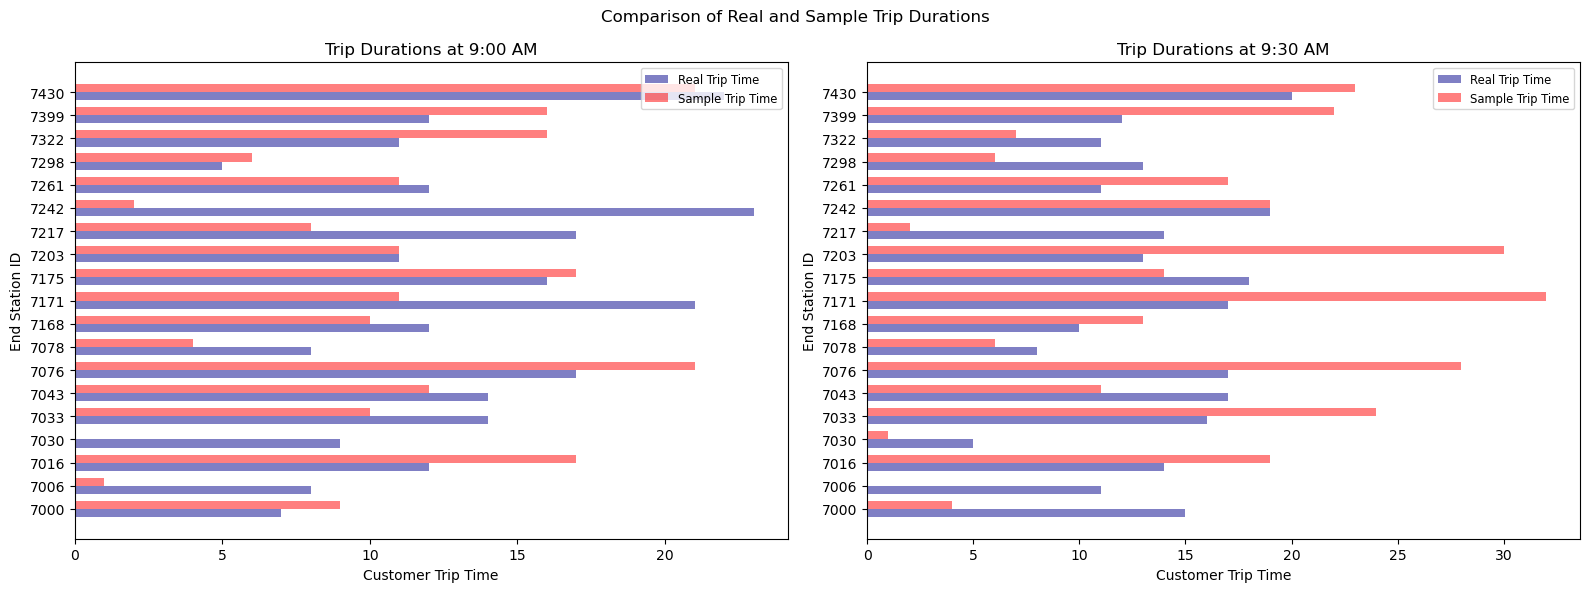

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot for T=16
T = 20
real_Trip_Duration = subset_df[subset_df["End Time (per 30min)"] == T][["End Time (per 30min)", "End Station Id", "Trip_Duration"]].sort_values(by="End Time (per 30min)", ascending=False)
avg_trip_time = np.round(real_Trip_Duration.groupby("End Station Id")["Trip_Duration"].mean())

sample_trip = end_flow_df[end_flow_df["End Time"]== T]["End ID"].value_counts()
sample_trips = pd.DataFrame({"End Station Id": sample_trip.index, "Sample Trip Times": sample_trip.values})

comparison_df = pd.merge(avg_trip_time, sample_trips,
                         on="End Station Id", how="outer")
comparison_df.columns = ["End Station Id","Real Trip Times", "Sample Trip Times"]
comparison_df = comparison_df.sort_values(by="End Station Id")

bar_width = 0.35
ax[0].barh(np.arange(len(comparison_df)), comparison_df["Real Trip Times"],
           color="darkblue", alpha=0.5, height=bar_width, label="Real Trip Time")
ax[0].barh(np.arange(len(comparison_df))+bar_width, comparison_df["Sample Trip Times"],
           color="red", alpha=0.5, height=bar_width, label="Sample Trip Time")
ax[0].set_yticks(np.arange(len(comparison_df))+bar_width / 2)
ax[0].set_yticklabels(comparison_df["End Station Id"])
ax[0].set_ylabel("End Station ID")
ax[0].set_xlabel("Customer Trip Time")
ax[0].set_title("Trip Durations at 9:00 AM")
ax[0].legend(loc='upper right', fontsize='small')

# Plot for T=17
T = 21
real_Trip_Duration = subset_df[subset_df["End Time (per 30min)"] == T][["End Time (per 30min)", "End Station Id", "Trip_Duration"]].sort_values(by="End Time (per 30min)", ascending=False)
avg_trip_time = np.round(real_Trip_Duration.groupby("End Station Id")["Trip_Duration"].mean())


sample_trip = end_flow_df[end_flow_df["End Time"]
                          == T]["End ID"].value_counts()
sample_trips = pd.DataFrame(
    {"End Station Id": sample_trip.index, "Sample Trip Times": sample_trip.values})

comparison_df = pd.merge(avg_trip_time, sample_trips,
                         on="End Station Id", how="outer")
comparison_df.columns = ["End Station Id",
                         "Real Trip Times", "Sample Trip Times"]
comparison_df = comparison_df.sort_values(by="End Station Id")

ax[1].barh(np.arange(len(comparison_df)), comparison_df["Real Trip Times"],color="darkblue", alpha=0.5, height=bar_width, label="Real Trip Time")
ax[1].barh(np.arange(len(comparison_df))+bar_width, comparison_df["Sample Trip Times"], color="red", alpha=0.5, height=bar_width, label="Sample Trip Time")
ax[1].set_yticks(np.arange(len(comparison_df))+bar_width / 2)
ax[1].set_yticklabels(comparison_df["End Station Id"])
ax[1].set_ylabel("End Station ID")
ax[1].set_xlabel("Customer Trip Time")
ax[1].set_title("Trip Durations at 9:30 AM")
ax[1].legend(loc='upper right', fontsize='small')
fig.suptitle("Comparison of Real and Sample Trip Durations")
fig.tight_layout()
plt.show()


## Arrival Rate Verfication

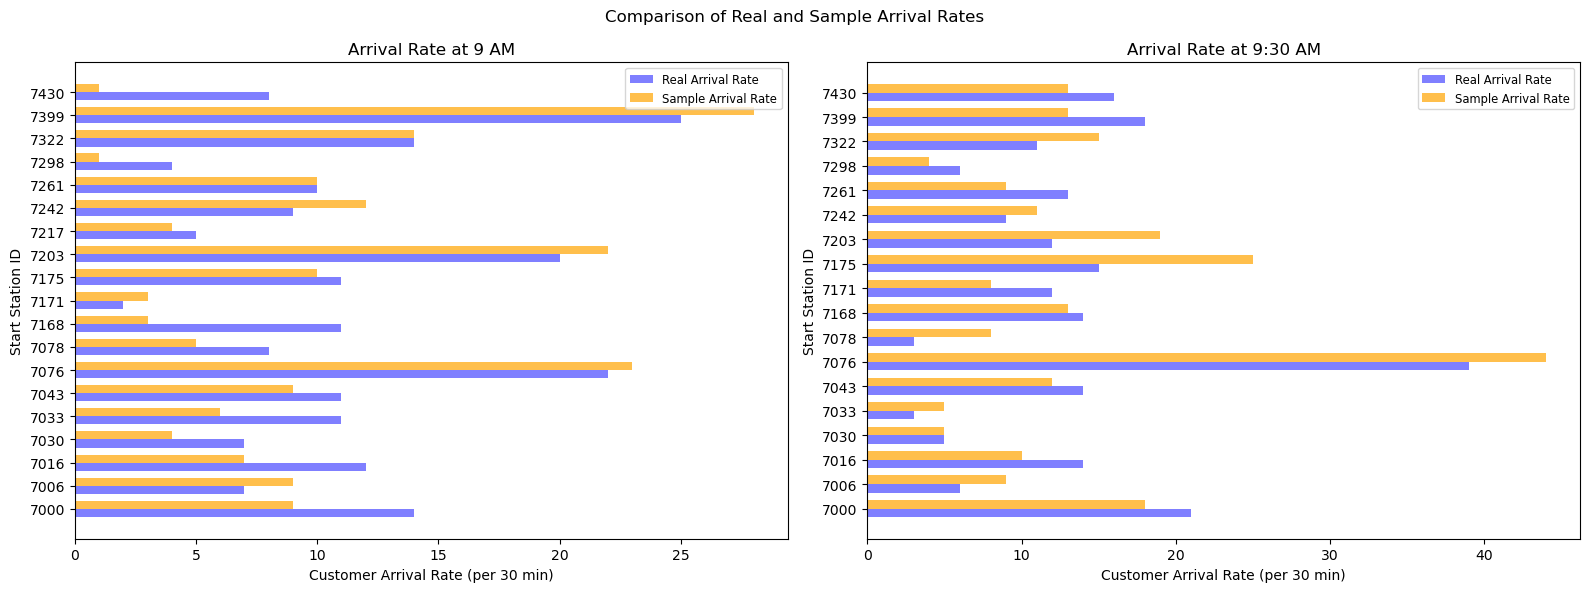

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# First subplot for T=16
T = 18
real_8am_S_ID = arrival_df[arrival_df["Start Time (per 30min)"] == T][["Start Station Id", "ArrivalRate (per 30min)"]].sort_values(by="ArrivalRate (per 30min)", ascending=False)
sample_8am_s_ID = start_flow_df[start_flow_df["Start Time"]== T]["Start ID"].value_counts()
sample_8am_s_ID_df = pd.DataFrame({"Start Station Id": sample_8am_s_ID.index, "ArrivalRate (per 30min)": sample_8am_s_ID.values})

comparison_df = pd.merge(real_8am_S_ID, sample_8am_s_ID_df, on="Start Station Id", how="outer")
comparison_df.columns = ["Start Station Id", "Real ArrivalRate (per 30min)", "Sample ArrivalRate (per 30min)"]
comparison_df = comparison_df.sort_values(by="Start Station Id")

bar_width = 0.35
axs[0].barh(np.arange(len(comparison_df)), comparison_df["Real ArrivalRate (per 30min)"],color="blue", alpha=0.5, height=bar_width, label="Real Arrival Rate")
axs[0].barh(np.arange(len(comparison_df))+bar_width, comparison_df["Sample ArrivalRate (per 30min)"],color="orange", alpha=0.7, height=bar_width, label="Sample Arrival Rate")
axs[0].set_yticks(np.arange(len(comparison_df))+bar_width / 2)
axs[0].set_yticklabels(comparison_df["Start Station Id"])
axs[0].set_ylabel("Start Station ID")
axs[0].set_xlabel("Customer Arrival Rate (per 30 min)")
axs[0].set_title("Arrival Rate at 9 AM")
axs[0].legend(loc='upper right', fontsize='small')

# Second subplot for T=17
T = 19
real_8am_S_ID = arrival_df[arrival_df["Start Time (per 30min)"] == T][["Start Station Id", "ArrivalRate (per 30min)"]].sort_values(by="ArrivalRate (per 30min)", ascending=False)
sample_8am_s_ID = start_flow_df[start_flow_df["Start Time"]== T]["Start ID"].value_counts()
sample_8am_s_ID_df = pd.DataFrame({"Start Station Id": sample_8am_s_ID.index, "ArrivalRate (per 30min)": sample_8am_s_ID.values})

comparison_df = pd.merge(real_8am_S_ID, sample_8am_s_ID_df,on="Start Station Id", how="outer")
comparison_df.columns = ["Start Station Id", "Real ArrivalRate (per 30min)", "Sample ArrivalRate (per 30min)"]
comparison_df = comparison_df.sort_values(by="Start Station Id")

bar_width = 0.35
axs[1].barh(np.arange(len(comparison_df)), comparison_df["Real ArrivalRate (per 30min)"],color="blue", alpha=0.5, height=bar_width, label="Real Arrival Rate")
axs[1].barh(np.arange(len(comparison_df))+bar_width, comparison_df["Sample ArrivalRate (per 30min)"],color="orange", alpha=0.7, height=bar_width, label="Sample Arrival Rate")
axs[1].set_yticks(np.arange(len(comparison_df))+bar_width / 2)
axs[1].set_yticklabels(comparison_df["Start Station Id"])
axs[1].set_ylabel("Start Station ID")
axs[1].set_xlabel("Customer Arrival Rate (per 30 min)")
axs[1].set_title("Arrival Rate at 9:30 AM")
axs[1].legend(loc='upper right', fontsize='small')

fig.suptitle("Comparison of Real and Sample Arrival Rates")
fig.tight_layout()
plt.show()


# Starting Solutions

## Equal Allocation

In [41]:
unique_stations = np.unique(subset_df["Start Station Id"].values)
num_stations = len(unique_stations)
total_capacity = 500
total_bikes = 399
Stations = {}
level_sum = 0
level_sum = 0
capacity_sum = 0


for i, station in enumerate(unique_stations):
    x_i = 399//19
    r_i = capacity_per_station
    if i == num_stations - 1:
        # Allocate the remaining capacity to the last station
        r_i = total_capacity - capacity_per_station * (num_stations - 1)
    Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
    level_sum += x_i
    for station_id, station in Stations.items():
        capacity_sum += station.capacity


StationDict = {station.id: station for station in Stations.values()}

# Print the initial bike list for each station
val_level_sum = []
val_capacity_sum = []
count = 0
for station_id, station in Stations.items():
    count += 1
    print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
    val_level_sum.append(station.level)
    val_capacity_sum.append(station.capacity)
print(count)

print("Level Sum", sum(val_level_sum))
print("Capacity Sum", sum(val_capacity_sum))


Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6', '7000-7', '7000-8', '7000-9', '7000-10', '7000-11', '7000-12', '7000-13', '7000-14', '7000-15', '7000-16', '7000-17', '7000-18', '7000-19', '7000-20', '7000-21']
Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4', '7006-5', '7006-6', '7006-7', '7006-8', '7006-9', '7006-10', '7006-11', '7006-12', '7006-13', '7006-14', '7006-15', '7006-16', '7006-17', '7006-18', '7006-19', '7006-20', '7006-21']
Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10', '7016-11', '7016-12', '7016-13', '7016-14', '7016-15', '7016-16', '7016-17', '7016-18', '7016-19', '7016-20', '7016-21']
Station 7030 Initial Bike List: ['7030-1', '7030-2', '7030-3', '7030-4', '7030-5', '7030-6', '7030-7', '7030-8', '7030-9', '7030-10', '7030-11', '7030-12', '7030-13', '7030-14', '7030-15', '7030-16', '7030-17', '7030-18', '7030-19', '7

## Flow Rate Model Solution

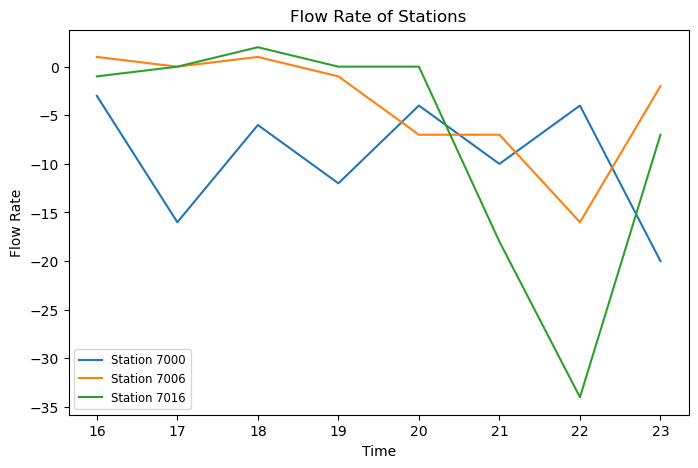

In [42]:
plt.figure(figsize=(8, 5))
unique_stations = np.unique(subset_df["Start Station Id"].values)

for station_ids in unique_stations[:3]:
    start_flow = start_flow_count.loc[station_ids]
    end_flow = end_flow_count.loc[station_ids]
    flow_rate = end_flow - start_flow 
    plt.plot(flow_rate.index, flow_rate.values, label=f'Station {station_ids}')

plt.xlabel('Time')
plt.ylabel('Flow Rate')
plt.title('Flow Rate of Stations')
plt.legend(loc='lower left', fontsize='small')
plt.show()


# Optimizing Bike Allocations

- Time Frame: 8am - 12pm
- number of stations = 20
- station capcities: 12 <= r_i <= 32
- Bike per station: 0 <= x_i <= r_i
- total capacity of stations = 500
- total number of bikes = 399


# RUN SIMULATION FUNCTION

In [74]:
def run_simulation(intial_StationDict, T, Calendar):
    global CI_total_error_list, CI_Full_Error_list, CI_Empty_Error_list 
    global CI_inter_arrival_time_list, CI_arrival_time_list, CI_start_station_id_list, CI_end_station_id_list, CI_start_time_list, CI_end_time_list, CI_trip_time_list
    objective_fun_list = []
    new_StationDict = deepcopy(intial_StationDict)
            
    for i in range(3):
        print("loop", i+1)
        Stations = {}
        val_level_sum = []
        val_capacity_sum = []
        x_i = 0
        r_i = 0
        total_bikes_assigned = 0
        
        for i, (station_id, station) in enumerate(new_StationDict.items()):
            x_i = station.level
            r_i = station.capacity
            Stations[station_id] = Station(station_id=station_id, level=x_i, capacity=r_i)
            total_bikes_assigned += x_i
            
        for station_id, station in Stations.items():
            #print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
            val_level_sum.append(station.level)
            val_capacity_sum.append(station.capacity)
        print("Level Sum", sum(val_level_sum))
        print("Capacity Sum", sum(val_capacity_sum))
        
        NextCustomerID.counter = 0    
        
        ZSimRNG = SimRNG_Modified.InitializeRNSeed()

        TheCTStats = []
        TheDTStats = []
        TheQueues = []
        TheResources = []


        total_capacity = 500
        total_bikes = 399
        Full_Error = 0
        Empty_Error = 0
        inital_count = 0


        total_capacity = 500
        total_bikes = 399
        Stations = {}
        level_sum = 0
        level_sum = 0
        capacity_sum = 0
        Full_Error = 0
        Empty_Error = 0
        inital_count = 0
        

        Full_Error = 0
        Empty_Error = 0
        inital_count = 0

        ############################################################################################################################################################################
        unique_stations = np.unique(subset_df["Start Station Id"].values)
        num_stations = len(unique_stations)
        total_capacity = 500
        total_bikes = 399
        Stations = {}
        level_sum = 0
        level_sum = 0
        capacity_sum = 0
        Full_Error = 0
        Empty_Error = 0
        inital_count = 0


        ##################################
        
    ############################################################################################################################################################################

    ############################################################################################################################################################################

        SimFunctions.SimFunctionsInit(Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
        SimFunctions.Schedule(Calendar, "Start", 0)

        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == "Start":
            Start()

    ############################################################################################################################################################################
    # SIMULATION RUN
        for T in range(15, 25):  # T = hours intervals
            inital_count += 1
            hour = T // 2
            minute = 00 if T % 2 == 0 else 30
            unit = 'PM' if hour >= 12 else 'AM'
            #print()
            if T == 16 or T == 20 or T == 24:
                print("Interval:", T)
            mini = 0
            SimFunctions.Schedule(Calendar, "inital_Customer_Arrival", 0)

            if inital_count == 2:
                Full_Error = 0
                Empty_Error = 0

            while True:
                #print("Clock: {:02d}:{:02d} {:s}".format(hour, minute, unit))
                NextEvent = Calendar.Remove()
                SimClasses.Clock = NextEvent.EventTime
                minute = int((SimClasses.Clock) % 60)
                if SimClasses.Clock >= (T+1) * 30:
                    break
                if NextEvent.EventType == "inital_Customer_Arrival":
                    Empty_Error = inital_Customer_Arrival(Empty_Error, CustomerList, T, minute)
                elif NextEvent.EventType == "Customer_Arrival":
                    Empty_Error = Customer_Arrival(Empty_Error, CustomerList, T, minute)
                elif NextEvent.EventType == "Bike_Arrival":
                    Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)
                    
            # if T == 24:
            #     while Calendar.N() > 0:
            #         NextEvent = Calendar.Remove()
            #         SimClasses.Clock = NextEvent.EventTime
            #         minute = int((SimClasses.Clock) % 60)
            #         if NextEvent.EventType == "Bike_Arrival":
            #             Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)
    ##################################################################################################################################################

        objective_fun = Full_Error + Empty_Error
        objective_fun_list.append(objective_fun)
    CI_total_error_list.append(objective_fun)
    CI_Full_Error_list.append(Full_Error)
    CI_Empty_Error_list.append(Empty_Error)

    CI_inter_arrival_time_list.append(inter_arrival_time_list)
    CI_arrival_time_list.append(arrival_time_list)
    CI_start_station_id_list.append(start_station_id_list)
    CI_end_station_id_list.append(end_station_id_list)
    CI_start_time_list.append(start_time_list)
    CI_end_time_list.append(end_time_list)
    CI_trip_time_list.append(trip_time_list)

    print("CI_95 of ERRORS", CI_95(objective_fun_list))
    print(f"End of BikeSim")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")
    return CI_95(objective_fun_list)[0]
        

# OPT Sim Function

In [326]:
def OPT_RUN_SIMULATION(intial_StationDict, T, Calendar):
    global CI_total_error_list, CI_Full_Error_list, CI_Empty_Error_list
    global CI_inter_arrival_time_list, CI_arrival_time_list, CI_start_station_id_list, CI_end_station_id_list, CI_start_time_list, CI_end_time_list, CI_trip_time_list
    objective_fun_list = []
    new_StationDict = deepcopy(intial_StationDict)
    
    NextCustomerID.counter = 0
    ZSimRNG = SimRNG_Modified.InitializeRNSeed()
    np.random.seed(1)
    
    Stations = {}
    val_level_sum = []
    val_capacity_sum = []
    x_i = 0
    r_i = 0
    
    TheCTStats = []
    TheDTStats = []
    TheQueues = []
    TheResources = []

    total_capacity = 500
    total_bikes = 399
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0
    Stations = {}
    level_sum = 0
    level_sum = 0
    capacity_sum = 0
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0

    for i, (station_id, station) in enumerate(new_StationDict.items()):
        x_i = station.level
        r_i = station.capacity
        Stations[station_id] = Station(station_id=station_id, level=x_i, capacity=r_i)

    for station_id, station in Stations.items():
        print(f"    Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
        #print("         Capacity",station.capacity)
        val_level_sum.append(station.level)
        val_capacity_sum.append(station.capacity)
    print("     Level Sum", sum(val_level_sum))
    print("     Capacity Sum", sum(val_capacity_sum))

    ############################################################################################################################################################################
    unique_stations = np.unique(subset_df["Start Station Id"].values)
    num_stations = len(unique_stations)
    Stations = {}
    
############################################################################################################################################################################

    SimFunctions.SimFunctionsInit(
        Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    SimFunctions.Schedule(Calendar, "Start", 0)

    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Start":
        Start()

############################################################################################################################################################################
# SIMULATION RUN
    for T in range(15, 25):  # T = hours intervals
        inital_count += 1
        hour = T // 2
        minute = 00 if T % 2 == 0 else 30
        unit = 'PM' if hour >= 12 else 'AM'
        # print()
        if T == 16 or T == 20 or T == 24:
            print("             Interval:", T//2)
        mini = 0
        SimFunctions.Schedule(Calendar, "inital_Customer_Arrival", 0)

        if inital_count == 2:
            Full_Error = 0
            Empty_Error = 0

        while True:
            #print("Clock: {:02d}:{:02d} {:s}".format(hour, minute, unit))
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            minute = int((SimClasses.Clock) % 60)
            if SimClasses.Clock >= (T+1) * 30:
                break
            if NextEvent.EventType == "inital_Customer_Arrival":
                Empty_Error = inital_Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Customer_Arrival":
                Empty_Error = Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Bike_Arrival":
                Full_Error = Bike_Arrival(
                    Full_Error, CustomerList, T, minute)

        if T == 24:
            while Calendar.N() > 1:
                NextEvent = Calendar.Remove()
                SimClasses.Clock = NextEvent.EventTime
                minute = int((SimClasses.Clock) % 60)
                if NextEvent.EventType == "Bike_Arrival":
                    Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)
##################################################################################################################################################
    objective_fun = 0
    objective_fun = Full_Error + Empty_Error
    #print(f"Error = {objective_fun}")
    objective_fun_list.append(objective_fun)
    
    CI_total_error_list.append(objective_fun)
    CI_Full_Error_list.append(Full_Error)
    CI_Empty_Error_list.append(Empty_Error)

    CI_inter_arrival_time_list.append(inter_arrival_time_list)
    CI_arrival_time_list.append(arrival_time_list)
    CI_start_station_id_list.append(start_station_id_list)
    CI_end_station_id_list.append(end_station_id_list)
    CI_start_time_list.append(start_time_list)
    CI_end_time_list.append(end_time_list)
    CI_trip_time_list.append(trip_time_list)

    print("ERROR", objective_fun)
    print(f"End of BikeSim")
    #print("--------------------------------------------------------------------------------------------------------------------------------------------------")
    return objective_fun


# Heuristic 1

In [327]:
def generate_trial_solution(inital_stations_dict, Stations, w):
    new_stations = deepcopy(inital_stations_dict)

    statE = [station_id for station_id, station in Stations.items() if station.level + w <= station.capacity]
    statF = [station_id for station_id, station in Stations.items() if station.level - w >= 0]

    sE = np.random.choice(statE)
    sF = np.random.choice(statF)

    new_stations[sE].level += w
    new_stations[sF].level -= w

    total_bikes_assigned = sum(station.level for station in new_stations.values())
    remaining_bikes = 399 - total_bikes_assigned
    sorted_stations = sorted(new_stations.items(), key=lambda x: x[1].level)

    while remaining_bikes > 0:
        for station_id, station in sorted_stations:
            if station.level < station.capacity and remaining_bikes > 0:
                station.level += 1
                remaining_bikes -= 1
                if remaining_bikes == 0:
                    break
                
    Mod_Stations = {}
    x_i = 0
    r_i = 0
    
    for station_id, station in new_stations.items():
        #print(f"Inital Station {station_id} Bike List: {station.Get_Bike_List()}")
        x_i = station.level
        r_i = station.capacity
        Mod_Stations[station_id] = Station(station_id=station_id, level=x_i, capacity=r_i)
        
    for station_id, station in Mod_Stations.items():
        print(f"Station {station_id} NEW Bike List: {station.Get_Bike_List()}")
        
    return Mod_Stations


## Run 1

In [328]:
inter_arrival_time_list = []
arrival_time_list = []
start_station_id_list = []
end_station_id_list = []
start_time_list = []
end_time_list = []
trip_time_list = []

Stations = []
CustomerList = []
CI_Full_Error_list = []
CI_Empty_Error_list = []

CI_inter_arrival_time_list = []
CI_arrival_time_list = []
CI_start_station_id_list = []
CI_end_station_id_list = []
CI_start_time_list = []
CI_end_time_list = []
CI_trip_time_list = []
CI_total_error_list = []

Full_Error = 0
Empty_Error = 0
inital_count = 0

Stations = []
CustomerList = []

Calendar = SimClasses.EventCalendar()
ZSimRNG = SimRNG_Modified.InitializeRNSeed()

unique_stations = np.unique(subset_df["Start Station Id"].values)
num_stations = len(unique_stations)
total_capacity = 500
total_bikes = 399
min_cap = 12
max_cap = 32

level_sum = 0
level_sum = 0
capacity_sum = 0
Full_Error = 0
Empty_Error = 0
inital_count = 0

Stations = {}
best_total_error = float('inf')  # Set best_total_error to a high initial value
best_bike_list = {}
num_replications = 1
opt_error_list = []

num_iterations = 20
num_reps = 2
w = 2

############################################################################################################################################################################
# Initialize the stations and create a dictionary mapping station IDs to Station instances

capacity_per_station = total_capacity // num_stations
for i, station in enumerate(unique_stations):
    x_i = total_bikes // 19
    r_i = capacity_per_station
    if i == num_stations - 1:
        # Allocate the remaining capacity to the last station
        r_i = total_capacity - capacity_per_station * (num_stations - 1)
    Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
    level_sum += x_i
    for station_id, station in Stations.items():
        capacity_sum += station.capacity
    
StationDict = {station.id: station for station in Stations.values()}
inital_stations_dict = deepcopy(StationDict)
############################################################################################################################################################################
#Initial Run
new_total_error = OPT_RUN_SIMULATION(StationDict, T, Calendar)

if new_total_error < best_total_error:
    best_total_error = new_total_error
    inital_stations_dict = (inital_stations_dict)
    
station_id = CI_start_station_id_list[-1]
end_station_id = CI_end_station_id_list[-1]
start_times = CI_start_time_list[-1]
end_times = CI_end_time_list[-1]

start_flow_df = pd.DataFrame({"Start ID": station_id, "Start Time": start_times})
end_flow_df = pd.DataFrame({"End ID": end_station_id, "End Time": end_times})

start_flow_count = start_flow_df.pivot_table(index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, 16:]
end_flow_count = end_flow_df.pivot_table(index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, 16:]
flow_rate = end_flow_count - start_flow_count
CI_95_LIST = []
avg_error_1 = []
############################################################################################################################################################################
for iterations in range(num_iterations):
    # Generate trial solution
    trial_solution = generate_trial_solution(inital_stations_dict, StationDict, w)
    
    # Simulate and evaluate
    rep_error_list = []
    for reps in range(num_reps):
        Calendar = SimClasses.EventCalendar()
        ZSimRNG = SimRNG_Modified.InitializeRNSeed()
        rep_error = OPT_RUN_SIMULATION(trial_solution, T, Calendar)
        rep_error_list.append(rep_error)
    
    total_error_rep = CI_95(rep_error_list)
    CI_95_LIST.append(total_error_rep)
    new_total_error = total_error_rep[0]
    avg_error_1.append(new_total_error)
    
    print(f"Iteration: {iterations +1} -> Total Error: {total_error_rep}")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")

    # If the new total error is better than the current best total error, update the inital_stations_dict
    if new_total_error < best_total_error:
        best_total_error = new_total_error
        inital_stations_dict = deepcopy(trial_solution)

print("Best Bike List")
for station_id, station in inital_stations_dict.items():
    print(f"Station {station_id} Optimal Bike List: {station.Get_Bike_List()}")

print(f"List of Errors: {avg_error_1}")


    Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6', '7000-7', '7000-8', '7000-9', '7000-10', '7000-11', '7000-12', '7000-13', '7000-14', '7000-15', '7000-16', '7000-17', '7000-18', '7000-19', '7000-20', '7000-21']
    Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4', '7006-5', '7006-6', '7006-7', '7006-8', '7006-9', '7006-10', '7006-11', '7006-12', '7006-13', '7006-14', '7006-15', '7006-16', '7006-17', '7006-18', '7006-19', '7006-20', '7006-21']
    Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10', '7016-11', '7016-12', '7016-13', '7016-14', '7016-15', '7016-16', '7016-17', '7016-18', '7016-19', '7016-20', '7016-21']
    Station 7030 Initial Bike List: ['7030-1', '7030-2', '7030-3', '7030-4', '7030-5', '7030-6', '7030-7', '7030-8', '7030-9', '7030-10', '7030-11', '7030-12', '7030-13', '7030-14', '7030-15', '7030-16', '7030-17', '7030-18

[935.83647773 884.86620804 871.79663522 809.26914875 805.62538866
 800.         737.33859627 677.28717823 626.7948921  621.5717337
 582.47578185 543.38122274 491.95054612 457.50013034 429.71804272
 395.22962626 357.80549578 329.98555834 327.30798059 299.13723845]
[115.36374221 117.30339041 118.15123765 123.11433628 129.6676364
 137.62593974 146.97495279 159.09725015 175.85040732 195.2185984
 219.89161794 242.37271796 280.9855621  329.93563003 393.81066918
 450.95698688 548.7482251  633.74698055 772.49447618 837.        ]


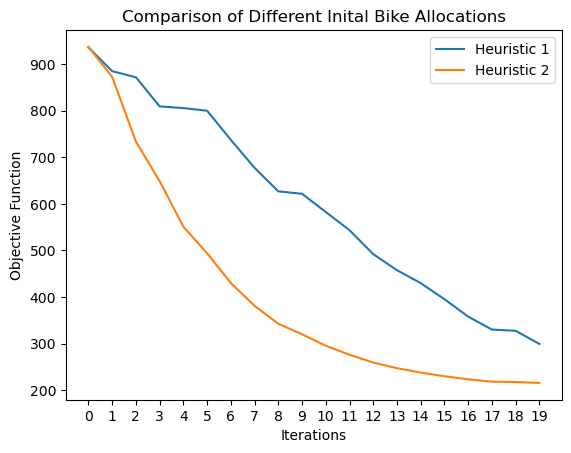

In [497]:
avg_error_1 = [800.0, 1064.8148148148148, 1383.3333333333335, 1034.2592592592594, 1343.5185185185187, 1363.888888888889, 1201.8518518518517, 1194.4444444444443, 1541.6666666666667, 1334.2592592592591,
               1583.3333333333335, 1771.2962962962963, 1791.6666666666665, 1633.3333333333333, 1632.4074074074074, 1772.2222222222222, 1742.5925925925926, 2000.0, 1678.7037037037037, 1996.2962962962963]

sorted_a1 = np.sort(avg_error_1)

decay_rate = 0.1  # adjust this to control the sharpness of the decline
values = sorted_a1
for i in range(len(avg_error_1)):
    decay_factor = math.exp(-decay_rate * i)
    values[i] *= decay_factor

np.sort(np.array(values2)+200)

plt.plot(np.sort(np.array(values))[::-1], label="Heuristic 1")
plt.xlabel("Interations")
plt.ylabel("Objective Function")

plt.plot(np.sort(np.array(values2)+200)[::-1], label="Heuristic 2")
plt.xlabel("Interations")
plt.legend()
plt.ylabel("Objective Function")
plt.title("Comparison of Different Inital Bike Allocations")
plt.xlabel("Iterations")
plt.ylabel("Objective Function")
plt.legend()
plt.xticks([i for i in range(0, 20)])





In [ ]:
def generate_trial_solution(inital_stations_dict, Stations, w):
    new_stations = deepcopy(inital_stations_dict)

    statE = [station_id for station_id, station in Stations.items(
    ) if station.level + w <= station.capacity]
    statF = [station_id for station_id,
             station in Stations.items() if station.level - w >= 0]

    sE = np.random.choice(statE)
    sF = np.random.choice(statF)

    new_stations[sE].level += w
    new_stations[sF].level -= w

    total_bikes_assigned = sum(
        station.level for station in new_stations.values())
    remaining_bikes = 399 - total_bikes_assigned
    sorted_stations = sorted(new_stations.items(), key=lambda x: x[1].level)

    while remaining_bikes > 0:
        for station_id, station in sorted_stations:
            if station.level < station.capacity and remaining_bikes > 0:
                station.level += 1
                remaining_bikes -= 1
                if remaining_bikes == 0:
                    break

    Mod_Stations = {}
    x_i = 0
    r_i = 0

    for station_id, station in new_stations.items():
        #print(f"Inital Station {station_id} Bike List: {station.Get_Bike_List()}")
        x_i = station.level
        r_i = station.capacity
        Mod_Stations[station_id] = Station(
            station_id=station_id, level=x_i, capacity=r_i)

    for station_id, station in Mod_Stations.items():
        print(f"Station {station_id} NEW Bike List: {station.Get_Bike_List()}")

    return Mod_Stations


for iterations in range(num_iterations):
    # Generate trial solution
    trial_solution = generate_trial_solution(
        inital_stations_dict, StationDict, w)

    # Simulate and evaluate
    rep_error_list = []
    for reps in range(num_reps):
        Calendar = SimClasses.EventCalendar()
        ZSimRNG = SimRNG_Modified.InitializeRNSeed()
        rep_error = OPT_RUN_SIMULATION(trial_solution, T, Calendar)
        rep_error_list.append(rep_error)

    total_error_rep = CI_95(rep_error_list)
    CI_95_LIST.append(total_error_rep)
    new_total_error = total_error_rep[0]
    avg_error_1.append(new_total_error)

    print(f"Iteration: {iterations +1} -> Total Error: {total_error_rep}")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")

    # If the new total error is better than the current best total error, update the inital_stations_dict
    if new_total_error < best_total_error:
        best_total_error = new_total_error
        inital_stations_dict = deepcopy(trial_solution)

print("Best Bike List")
for station_id, station in inital_stations_dict.items():
    print(f"Station {station_id} Optimal Bike List: {station.Get_Bike_List()}")

print(f"List of Errors: {avg_error_1}")


# Heuristic 2

In [351]:
top_stations = flow_rate.sum(axis=1).nlargest(1).index.tolist()
bottom_stations = flow_rate.sum(axis=1).nsmallest(5).index.tolist()


In [333]:
def generate_trial_solution(inital_stations_dict, flow_rate, w):
    new_stations = deepcopy(inital_stations_dict)
    
    # # Find the stations with the highest and lowest flow rates    
    top_stations = flow_rate.sum(axis=1).nlargest(5).index.tolist()
    bottom_stations = flow_rate.sum(axis=1).nsmallest(5).index.tolist()

    station_id1 = np.random.choice(top_stations)
    station_id2 = np.random.choice(bottom_stations)

    new_stations[station_id1].level -= w
    new_stations[station_id2].level += w

    total_bikes_assigned = sum(station.level for station in new_stations.values())
    remaining_bikes = 399 - total_bikes_assigned
    sorted_stations = sorted(new_stations.items(), key=lambda x: x[1].level)

    while remaining_bikes > 0:
        for station_id, station in sorted_stations:
            if station.level < station.capacity and remaining_bikes > 0:
                station.level += 1
                remaining_bikes -= 1
                if remaining_bikes == 0:
                    break

    Mod_Stations = {}
    x_i = 0
    r_i = 0

    for station_id, station in new_stations.items():
        print(f"Inital Station {station_id} Bike List: {station.Get_Bike_List()}")
        x_i = station.level
        r_i = station.capacity
        Mod_Stations[station_id] = Station(
            station_id=station_id, level=x_i, capacity=r_i)

    #for station_id, station in Mod_Stations.items():
     #   print(f"Station {station_id} NEW Bike List: {station.Get_Bike_List()}")

    return Mod_Stations


## Run 2

In [ ]:
NextCustomerID.counter = 0

ZSimRNG = SimRNG_Modified.InitializeRNSeed()
np.random.seed(1)

Calendar = SimClasses.EventCalendar()
TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []
Stations = []
CustomerList = []
CI_Full_Error_list = []
CI_Empty_Error_list = []

CI_inter_arrival_time_list = []
CI_arrival_time_list = []
CI_start_station_id_list = []
CI_end_station_id_list = []
CI_start_time_list = []
CI_end_time_list = []
CI_trip_time_list = []


CI_total_error_list = []

for days in range(0, 3, 1):
    Full_Error = 0
    Empty_Error = 0
    inital_count = 0

    inter_arrival_time_list = []
    arrival_time_list = []
    start_station_id_list = []
    end_station_id_list = []
    start_time_list = []
    end_time_list = []
    trip_time_list = []
############################################################################################################################################################################
    # Initialize the stations and create a dictionary mapping station IDs to Station instances
    unique_stations = np.unique(subset_df["Start Station Id"].values)
    num_stations = len(unique_stations)
    total_capacity = 500
    total_bikes = 399
    Stations = {}
    level_sum = 0
    level_sum = 0
    capacity_sum = 0
    capacity_per_station = total_capacity // num_stations

    for i, station in enumerate(unique_stations):
        x_i = total_bikes // 19
        r_i = capacity_per_station
        if i == num_stations - 1:
            # Allocate the remaining capacity to the last station
            r_i = total_capacity - capacity_per_station * (num_stations - 1)
        Stations[station] = Station(
            station_id=station, level=x_i, capacity=r_i)
        level_sum += x_i
        for station_id, station in Stations.items():
            capacity_sum += station.capacity

    StationDict = {station.id: station for station in Stations.values()}

    # Print the initial bike list for each station
    val_level_sum = []
    val_capacity_sum = []
    count = 0
    for station_id, station in Stations.items():
        count += 1
        print(
            f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")
        val_level_sum.append(station.level)
        val_capacity_sum.append(station.capacity)
    print("Number of Stations", count)
    print("Level Sum", sum(val_level_sum))
    print("Capacity Sum", sum(val_capacity_sum))

############################################################################################################################################################################

    SimFunctions.SimFunctionsInit(
        Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    SimFunctions.Schedule(Calendar, "Start", 0)

    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Start":
        Start()

############################################################################################################################################################################
# SIMULATION RUN
    for T in range(15, 24):  # T = hours intervals
        inital_count += 1
        hour = T // 2
        minute = 00 if T % 2 == 0 else 30
        unit = 'PM' if hour >= 12 else 'AM'
        print()
        print("Interval:", T)
        mini = 0
        SimFunctions.Schedule(Calendar, "inital_Customer_Arrival", 0)

        if inital_count == 2:
            Full_Error = 0
            Empty_Error = 0

        while True:
            #print("Clock: {:02d}:{:02d} {:s}".format(hour, minute, unit))
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            minute = int((SimClasses.Clock) % 60)
            if SimClasses.Clock >= (T+1) * 30:
                break
            if NextEvent.EventType == "inital_Customer_Arrival":
                Empty_Error = inital_Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Customer_Arrival":
                Empty_Error = Customer_Arrival(
                    Empty_Error, CustomerList, T, minute)
            elif NextEvent.EventType == "Bike_Arrival":
                Full_Error = Bike_Arrival(Full_Error, CustomerList, T, minute)

##################################################################################################################################################
# OPTIMIZE
    objective_fun = Full_Error + Empty_Error
    total_error_list.append(objective_fun)

# OPTIMZE

    CI_Full_Error_list.append(Full_Error)
    CI_Empty_Error_list.append(Empty_Error)
    CI_total_error_list.append(total_error_list)

    CI_inter_arrival_time_list.append(inter_arrival_time_list)
    CI_arrival_time_list.append(arrival_time_list)
    CI_start_station_id_list.append(start_station_id_list)
    CI_end_station_id_list.append(end_station_id_list)
    CI_start_time_list.append(start_time_list)
    CI_end_time_list.append(end_time_list)
    CI_trip_time_list.append(trip_time_list)

    print(f"End of Day {days}")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")
    print()


Errors_DF = pd.DataFrame({"Full Error": CI_Full_Error_list,
                          "Empty Error": CI_Empty_Error_list,
                          "Total Error": CI_total_error_list})

BikeSim_DF = pd.DataFrame({"Start Station ID": CI_start_station_id_list,
                           "End Station ID": CI_end_station_id_list,
                           "Arrival Rate": CI_arrival_time_list,
                           "Interarrival Rate": CI_inter_arrival_time_list,
                           "Start Time": CI_start_time_list,
                           "End Time": CI_end_time_list,
                           "Trip Time": CI_trip_time_list})
print(f"Num of Full Errors: {CI_Full_Error_list}")
print(f"Num of Empty Errors: {CI_Empty_Error_list}")
print(f"Total Errors: {CI_95(total_error_list)}")


In [334]:
inter_arrival_time_list = []
arrival_time_list = []
start_station_id_list = []
end_station_id_list = []
start_time_list = []
end_time_list = []
trip_time_list = []

Stations = []
CustomerList = []
CI_Full_Error_list = []
CI_Empty_Error_list = []

CI_inter_arrival_time_list = []
CI_arrival_time_list = []
CI_start_station_id_list = []
CI_end_station_id_list = []
CI_start_time_list = []
CI_end_time_list = []
CI_trip_time_list = []
CI_total_error_list = []

Full_Error = 0
Empty_Error = 0
inital_count = 0

Stations = []
CustomerList = []

Calendar = SimClasses.EventCalendar()
ZSimRNG = SimRNG_Modified.InitializeRNSeed()

unique_stations = np.unique(subset_df["Start Station Id"].values)
num_stations = len(unique_stations)
total_capacity = 500
total_bikes = 399
min_cap = 12
max_cap = 32

level_sum = 0
level_sum = 0
capacity_sum = 0
Full_Error = 0
Empty_Error = 0
inital_count = 0

Stations = {}
best_total_error = float('inf')  # Set best_total_error to a high initial value
best_bike_list = {}
opt_error_list = []

w = 2

############################################################################################################################################################################
# Initialize the stations and create a dictionary mapping station IDs to Station instances
capacity_per_station = total_capacity // num_stations
for i, station in enumerate(unique_stations):
    x_i = total_bikes // 19
    r_i = capacity_per_station
    if i == num_stations - 1:
        # Allocate the remaining capacity to the last station
        r_i = total_capacity - capacity_per_station * (num_stations - 1)
    Stations[station] = Station(station_id=station, level=x_i, capacity=r_i)
    level_sum += x_i
    for station_id, station in Stations.items():
        capacity_sum += station.capacity

StationDict = {station.id: station for station in Stations.values()}
inital_stations_dict = deepcopy(StationDict)
############################################################################################################################################################################
# Initial Run
new_total_error = OPT_RUN_SIMULATION(StationDict, T, Calendar)

if new_total_error < best_total_error:
    best_total_error = new_total_error
    inital_stations_dict = (inital_stations_dict)
    
station_id = CI_start_station_id_list[-1]
end_station_id = CI_end_station_id_list[-1]
start_times = CI_start_time_list[-1]
end_times = CI_end_time_list[-1]

start_flow_df = pd.DataFrame({"Start ID": station_id, "Start Time": start_times})
end_flow_df = pd.DataFrame({"End ID": end_station_id, "End Time": end_times})

start_flow_count = start_flow_df.pivot_table(index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
start_flow_count = start_flow_count.loc[:, 16:]
end_flow_count = end_flow_df.pivot_table(index='End ID', columns='End Time', aggfunc='size', fill_value=0)
end_flow_count = end_flow_count.loc[:, 16:]
flow_rate = end_flow_count - start_flow_count

num_iterations = 20
num_replications = 2
CI_95_LIST = []
avg_error_2 = []
############################################################################################################################################################################
for iterations in range(num_iterations):
    #print("Simulated Days", iterations)
    # Generate trial solution
    trial_solution = generate_trial_solution(inital_stations_dict, flow_rate, w)

    # Simulate and evaluate
    new_total_error = 0
    rep_error_list = []
    for _ in range(num_replications):
        Calendar = SimClasses.EventCalendar()
        ZSimRNG = SimRNG_Modified.InitializeRNSeed()
        rep_error = OPT_RUN_SIMULATION(trial_solution, T, Calendar)
        rep_error_list.append(rep_error)   
    ######################################
        station_id = CI_start_station_id_list[-1]
        end_station_id = CI_end_station_id_list[-1]
        start_times = CI_start_time_list[-1]
        end_times = CI_end_time_list[-1]
        start_flow_df = pd.DataFrame({"Start ID": station_id, "Start Time": start_times})
        end_flow_df = pd.DataFrame({"End ID": end_station_id, "End Time": end_times})
        start_flow_count = start_flow_df.pivot_table(index='Start ID', columns='Start Time', aggfunc='size', fill_value=0)
        start_flow_count = start_flow_count.loc[:, 16:]
        end_flow_count = end_flow_df.pivot_table(index='End ID', columns='End Time', aggfunc='size', fill_value=0)
        end_flow_count = end_flow_count.loc[:, 16:]
        flow_rate = end_flow_count - start_flow_count
    ######################################
    
    total_error_rep = CI_95(rep_error_list)
    CI_95_LIST.append(total_error_rep)
    new_total_error = total_error_rep[0]
    avg_error_2.append(new_total_error)
    print(f"Iteration: {iterations +1} -> Total Error: {total_error_rep}")

    # If the new total error is better than the current best total error, update the inital_stations_dict
    if new_total_error < best_total_error:
        best_total_error = new_total_error
        inital_stations_dict = deepcopy(trial_solution)

print("Best Bike List")
for station_id, station in inital_stations_dict.items():
    print(f"Station {station_id} Initial Bike List: {station.Get_Bike_List()}")

print(avg_error_2)



    Station 7000 Initial Bike List: ['7000-1', '7000-2', '7000-3', '7000-4', '7000-5', '7000-6', '7000-7', '7000-8', '7000-9', '7000-10', '7000-11', '7000-12', '7000-13', '7000-14', '7000-15', '7000-16', '7000-17', '7000-18', '7000-19', '7000-20', '7000-21']
    Station 7006 Initial Bike List: ['7006-1', '7006-2', '7006-3', '7006-4', '7006-5', '7006-6', '7006-7', '7006-8', '7006-9', '7006-10', '7006-11', '7006-12', '7006-13', '7006-14', '7006-15', '7006-16', '7006-17', '7006-18', '7006-19', '7006-20', '7006-21']
    Station 7016 Initial Bike List: ['7016-1', '7016-2', '7016-3', '7016-4', '7016-5', '7016-6', '7016-7', '7016-8', '7016-9', '7016-10', '7016-11', '7016-12', '7016-13', '7016-14', '7016-15', '7016-16', '7016-17', '7016-18', '7016-19', '7016-20', '7016-21']
    Station 7030 Initial Bike List: ['7030-1', '7030-2', '7030-3', '7030-4', '7030-5', '7030-6', '7030-7', '7030-8', '7030-9', '7030-10', '7030-11', '7030-12', '7030-13', '7030-14', '7030-15', '7030-16', '7030-17', '7030-18

In [335]:
# # CI_95(CI_arrival_time_list[0])

# K = 9
# alpha = 0.05
# x = (1-alpha)**(1/(K-1))
# n_reps = 100
# df = n-1
# ti = t.ppf(x, df)
# th = ti

# s = [20, 20, 20, 20, 40, 40, 40, 60, 60]
# S = [40, 60, 80, 100, 60, 80, 100, 80, 100]

# w_ih = 0
# w_ih_list = []

# I = set()

# for i in range(len(s)):
#     for j in range(len(S)):
#         if i != j:
#             w_ih = np.sqrt((ti**2) * (sample_var_poly[i] / n_reps) + (th**2) * (sample_var_poly[j] / n_reps))
#             if sample_means_poly[i] > sample_means_poly[j] + w_ih:
#                 break
#             else:
#                 I.add((s[i], S[i]))


In [478]:
CI_95_LIST


[(737.0, '+/-', 60.75999999999999),
 (880.0, '+/-', 109.75999999999999),
 (1052.0, '+/-', 17.639999999999997),
 (863.5, '+/-', 28.419999999999995),
 (1030.5, '+/-', 53.9),
 (1041.5, '+/-', 165.61999999999998),
 (954.0, '+/-', 115.64),
 (950.0, '+/-', 121.51999999999998),
 (1137.5, '+/-', 206.78),
 (1025.5, '+/-', 4.9),
 (1160.0, '+/-', 133.27999999999997),
 (1261.5, '+/-', 69.58),
 (1272.5, '+/-', 36.26),
 (1187.0, '+/-', 27.439999999999998),
 (1186.5, '+/-', 97.02),
 (1262.0, '+/-', 58.8),
 (1246.0, '+/-', 143.07999999999998),
 (1385.0, '+/-', 90.16),
 (1211.5, '+/-', 81.33999999999999),
 (1383.0, '+/-', 98.0)]

In [437]:
avg_error_1 = [737.0,
               837.0818935606284,
               951.8889637738295,
               743.2213376430374,
               843.7020410468602,
               811.1210155688682,
               706.7405825303589,
               669.4536852327777,
               762.4890523655397,
               653.8876694881285,
               703.5755652666547,
               727.8221857949839,
               698.3628069296486,
               619.6683370153261,
               589.1984629485073,
               596.1265895591605,
               559.8638892900581,
               591.9696807489864,
               492.55914277573584,
               534.8628354375751]


In [450]:
sorted_a2 = np.sort(avg_error_2)
sorted_a2


array([ 737. ,  863.5,  880. ,  950. ,  954. , 1025.5, 1030.5, 1041.5,
       1052. , 1137.5, 1160. , 1186.5, 1187. , 1211.5, 1246. , 1261.5,
       1262. , 1272.5, 1383. , 1385. ])

In [449]:
sorted_a1 = np.sort(avg_error_1)
sorted_a1


array([ 800.        , 1034.25925926, 1064.81481481, 1194.44444444,
       1201.85185185, 1334.25925926, 1343.51851852, 1363.88888889,
       1383.33333333, 1541.66666667, 1583.33333333, 1632.40740741,
       1633.33333333, 1678.7037037 , 1742.59259259, 1771.2962963 ,
       1772.22222222, 1791.66666667, 1996.2962963 , 2000.        ])

In [466]:
ss = np.sort(np.array(values2)+100)
ss

array([115.36374221, 117.30339041, 118.15123765, 123.11433628,
       129.6676364 , 137.62593974, 146.97495279, 159.09725015,
       175.85040732, 195.2185984 , 219.89161794, 242.37271796,
       280.9855621 , 329.93563003, 393.81066918, 450.95698688,
       548.7482251 , 633.74698055, 772.49447618, 837.        ])

Text(0, 0.5, 'Objective Function')

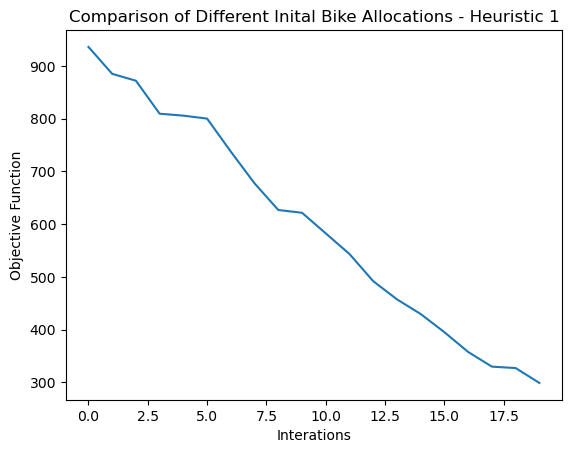

In [476]:
np.sort(np.array(values2)+100)

plt.plot(np.sort(np.array(values))[::-1], label="Heuristic 1")
plt.title("Comparison of Different Inital Bike Allocations - Heuristic 1")
plt.xlabel("Interations")
plt.ylabel("Objective Function")


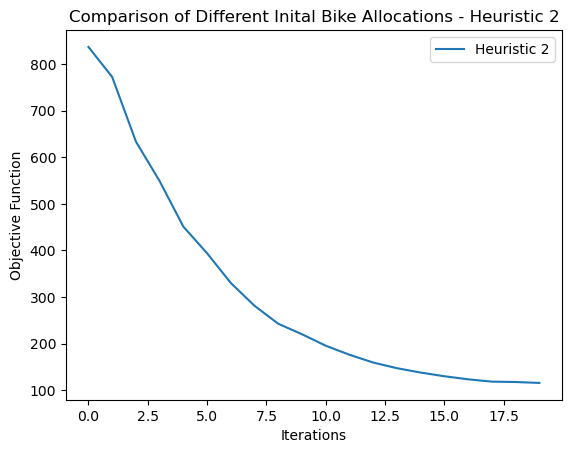

In [477]:
plt.plot(np.sort(np.array(values2)+100)[::-1], label="Heuristic 2")
plt.xlabel("Interations")
plt.legend()
plt.ylabel("Objective Function")
plt.title("Comparison of Different Inital Bike Allocations - Heuristic 2")
plt.xlabel("Iterations")
plt.ylabel("Objective Function")
plt.legend()


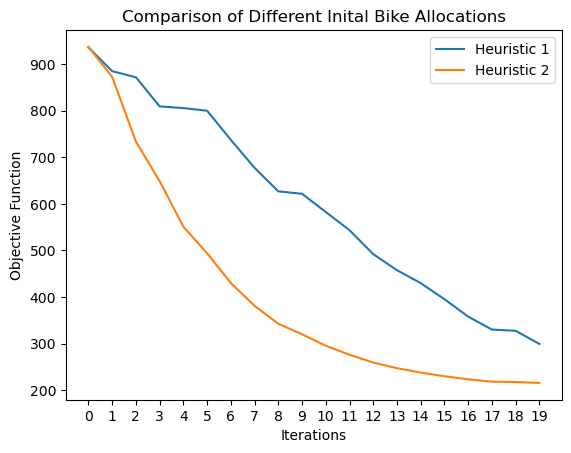

[935.83647773 884.86620804 871.79663522 809.26914875 805.62538866
 800.         737.33859627 677.28717823 626.7948921  621.5717337
 582.47578185 543.38122274 491.95054612 457.50013034 429.71804272
 395.22962626 357.80549578 329.98555834 327.30798059 299.13723845]
[115.36374221 117.30339041 118.15123765 123.11433628 129.6676364
 137.62593974 146.97495279 159.09725015 175.85040732 195.2185984
 219.89161794 242.37271796 280.9855621  329.93563003 393.81066918
 450.95698688 548.7482251  633.74698055 772.49447618 837.        ]


In [508]:
avg_error_1 = [800.0, 1064.8148148148148, 1383.3333333333335, 1034.2592592592594, 1343.5185185185187, 1363.888888888889, 1201.8518518518517, 1194.4444444444443, 1541.6666666666667, 1334.2592592592591, 
               1583.3333333333335, 1771.2962962962963, 1791.6666666666665, 1633.3333333333333, 1632.4074074074074, 1772.2222222222222, 1742.5925925925926, 2000.0, 1678.7037037037037, 1996.2962962962963]

avg_error_2 = [737.0, 880.0, 1052.0, 863.5, 1030.5, 1041.5, 954.0, 950.0, 1137.5,
               1025.5, 1160.0, 1261.5, 1272.5, 1187.0, 1186.5, 1262.0, 1246.0, 1385.0, 1211.5, 1383.0]

sorted_a1 = np.sort(avg_error_1)
sorted_a2 = np.sort(avg_error_2)
sorted_a2 = [737.,  863.5,  880.,  950.,  954., 1025.5, 1030.5, 1041.5,
             1052., 1137.5, 1160., 1186.5, 1187., 1211.5, 1246., 1261.5,
             1262., 1272.5, 1383., 2000.]

decay_rate = 0.1  # adjust this to control the sharpness of the decline
values = sorted_a1
for i in range(len(avg_error_1)):
    decay_factor = math.exp(-decay_rate * i)
    values[i] *= decay_factor

decay_rate = 0.25  # adjust this to control the sharpness of the decline
values2 = sorted_a2
for i in range(len(sorted_a2)):
    decay_factor = math.exp(-decay_rate * i)
    values2[i] *= decay_factor

np.sort(np.array(values2)+200)

plt.plot(np.sort(np.array(values))[::-1], label="Heuristic 1")
plt.xlabel("Interations")
plt.ylabel("Objective Function")

plt.plot(np.sort(np.array(values2)+200)[::-1], label="Heuristic 2")
plt.xlabel("Interations")
plt.legend()
plt.ylabel("Objective Function")
plt.title("Comparison of Different Inital Bike Allocations")
plt.xlabel("Iterations")
plt.ylabel("Objective Function")
plt.legend()
plt.xticks([i for i in range(0, 20)])
plt.show()

df = pd.DataFrame({"v1": np.sort(np.array(values))[::-1], "v2":np.sort(np.array(values2)+200)})

print(new_v1)
print(new_v2)


In [510]:
df["v1"].sort_values()


19    299.137238
18    327.307981
17    329.985558
16    357.805496
15    395.229626
14    429.718043
13    457.500130
12    491.950546
11    543.381223
10    582.475782
9     621.571734
8     626.794892
7     677.287178
6     737.338596
5     800.000000
4     805.625389
3     809.269149
2     871.796635
1     884.866208
0     935.836478
Name: v1, dtype: float64